In [1]:
import numpy as np
import pandas as pd
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import matplotlib.pyplot as plt
from astropy.table import Column, join, Table, vstack, hstack
from astropy.io import ascii
from HMXB_pipeline_class import pipeline
import astropy.coordinates as coords
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import astropy_mpl_style
import corner
from datetime import datetime
import os
import mw_plot

In [2]:

cwd = os.getcwd()
cwd

'/home/karan/Documents/UvA/Thesis/Code'

In [3]:
#constants
k  = 4.74 #km/s per mas/yr 

#solar values
# solar motion km/s 
# M. Carretero-Castrillo 2023 and Ried 2019
#km/s
U_sun = 10.8
V_sun = 13.6
W_sun = 7.6

global U_sun, V_sun, W_sun, k

today = datetime.now().strftime("%Y%m%d")

# Colors

In [4]:
    color_map = {
        "xkcd:blue": "O I-III",
        "xkcd:red": "B I-III",
        "xkcd:bright Blue": "Oe I-III",
        "xkcd:dark blue": "Oe IV-V",
        "xkcd:green": "B0e I-III",
        "xkcd:bright green": "B1e I-III",
        "xkcd:grass green": "B2e I-III",
        "xkcd:black": "OB IV-V",
        "xkcd:grey": "M,A,None",
        "xkcd:purple": "B0e IV-V",
        "xkcd:light purple": "B1e IV-V",
        "xkcd:dark purple": "B2e IV-V",
    }
    groups = [
        ("O I-III", ['xkcd:blue'], 'xkcd:blue'),
        ("B I-III", ['xkcd:red'], 'xkcd:red'),
        ("Oe", ['xkcd:bright Blue', 'xkcd:dark blue'], 'xkcd:cobalt'),
        ("Be I-III", ['xkcd:green', 'xkcd:bright green', 'xkcd:dark green'], 'xkcd:green')
    ]
    marker_map = {
        "xkcd:blue": 'o',   # Circle marker for "O I-III"
        "xkcd:red":'o',    # Circle marker for "B I-III"
        "xkcd:bright Blue": '^',  # Triangle marker for "Oe I-III"
        "xkcd:dark blue":'^',  # Triangle marker for "Oe IV-V"
        "xkcd:green": '^',  # Circle marker for "B0e I-III"
        "xkcd:bright green": '^',  # Circle marker for "B1e I-III"
        "xkcd:grass green":'^',  # Circle marker for "B2e I-III"
        "xkcd:black": 'x',   # Cross marker for "OB IV-V"
        "xkcd:grey": 'x',  # Cross marker for "M,A,None"
        "xkcd:purple": '^',  # Circle marker for "B0e IV-V"
        "xkcd:light purple": '^',  # Circle marker for "B1e IV-V"
        "xkcd:dark purple": '^'  # Circle marker for "B2e IV-V"
    }

# Read the Data
## DO NOT EDIT THIS FILE

In [5]:
#get the location of the data files
home_files = os.path.dirname(cwd)
home_files = home_files + '/'
csv_files  = home_files + 'DATA/'
csv_files

'/home/karan/Documents/UvA/Thesis/DATA/'

In [6]:
HMXB_gaia = ascii.read(csv_files+'GAIA_HMXB_DNE_ruwe.ecsv',format='ecsv')
HMXB_gaia

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.546486466252775,0.016773285,0.3391933399322079,0.01803902,--,--,11.412056,126.08000772759438,-3.5676859152271287,1.0861942
426558460884582016,14.177450998208093,1.8335997,60.71672280471204,2.3911946,--,--,--,--,--,--,--,--,2.0645833,123.57698659515256,-2.1484240190698634,--
427234969757165952,9.290132580203235,0.008413794,61.36013319063004,0.009818237,-1.7956235405295953,0.010947091,-0.5251300483100196,0.013608978,0.27189066538368456,0.012059882,--,--,9.454656,121.22141620023214,-1.4641898756122689,0.97518367
444752973131169664,53.749629724978455,0.013929484,53.17313997828423,0.012730369,-0.26805266659388,0.019742586,0.4401283844933388,0.019827945,0.13434727271763658,0.020151323,--,--,14.200214,146.05208942276994,-2.1940257086354467,1.0700557


# Update with Bailer Jones distances

https://dc.g-vo.org/__system__/adql/query/form

ADQL query: SELECT source_id, r_med_photogeo, r_lo_photogeo, r_hi_photogeo FROM gedr3dist.main AS ged Where ged.source_id IN (3441207615229815040,5336957010898124160,5334851450481641088,6053076566300433920,5255509901121774976,1979911002134040960,2021785421455305344,2033989790047905024,5862285700835092352,524924310153249920,5854175187680510336,6054569565614460800,5863533199843070208,524677469790488960,168450545792009600,5613494119551805184,5334823859608495104,5886085557746480000,4268774695647764352,4309225217336733824,4306419980916246656,2034031438383765760,2005653524280214400,5966213219190201856,4256500538116700160,4258160560148155648,2026914849346539008,252878401557369088,5489434710755238400,5337498593446516480,2178178409188167296,5883218164517055488,2059383668236814720,2063791369815322752,5258414192353423360,2065653598916388352,5523448274762133632,4278536022438800640,6055103928246312960,5864664975280537728,5884544931471259136,5976382915813535232,4060784345959549184,1982359580155628160,3431561565357225088,184497471323752064,5620657678322625920,5337747731560719616,3131822364779745536,5837600152935767680,427234969757165952,519352324516039680,518990967445248256,3423526544838563328,5541793213959987968,5522306019626566528,5259009543533179648,5339047221168787712,5333660129603575808,5335021664274920576,6054778507172454912,5878377736381364608,5935509395659726592,5934776158877214848,5940777877435137024,5940576971716473344,5940285090075838848,5943166184173519744,5943246345430928512,5980409632300781056,4054559284753424000,4063908810076415872,4070770243676311936,4070968778561141760,4146789141900648576,4152643113595580416,4253473896214500096,4259088994635370752,4258428501693172736,4309253392325650176,4323316622779495680,1978365123143522176,2207277877757956352,2031939548802102656,5352018121173519488,4104196427943626624,5548261400354128768,465645515129855872,2935943990338336000,5311384333263075840,3052677318793446016,4155023796790984064,5862299960127967488,3131755947406031104,2067835682818358400,511220031584305536,2083644392294059520,4097365235226829312,2162805896614571904,2201091578667140352,5597252305589385984,5862928537183584768,2070085317968809216,4155000844481174656,4293406612283985024,4156747212545110400,465628193526364416,5933976985766949376,414196617287885312,4512787627579740032,444752973131169664,276644757710014976,5882543824607819776,4056922105185686784,4040960662373474176,4255891924062617088,4310118570535453696,4310649153642824320,2028089540103670144,426558460884582016,6060547335455660032)


In [7]:
bailer_jones = ascii.read(csv_files+'Bailer_jones_distances.csv',format='csv')
bailer_jones['r_med_photogeo'] = bailer_jones['r_med_photogeo']/1000
bailer_jones['r_med_photogeo'].unit = u.kpc

bailer_jones['r_hi_photogeo'] = bailer_jones['r_hi_photogeo']/1000
bailer_jones['r_hi_photogeo'].unit = u.kpc

bailer_jones['r_lo_photogeo'] = bailer_jones['r_lo_photogeo']/1000
bailer_jones['r_lo_photogeo'].unit = u.kpc

In [8]:
#rename the columns 
bailer_jones.rename_columns(['r_med_photogeo', 'r_lo_photogeo', 'r_hi_photogeo'], ['distance_bj','distance_bj_low','distance_bj_high'])


In [9]:
HMXB_gaia = join(HMXB_gaia,bailer_jones,keys='source_id',join_type='left')

In [10]:
#add compact massHMXB_table
# compact = ascii.read(csv_files+'HMXB_compact_mass.csv',format='csv')
# compact = compact[~compact['source_id'].mask]

fortin = ascii.read(csv_files+'FortinHMXB.csv')

In [11]:
fortin['Main_ID'].name = 'Name'
#fortin_mass = fortin_mass[~fortin_mass['']]

In [12]:
fortin

Name,RAdeg,DEdeg,PosErr,Pos_ref,Spectype,Spectype_ref,Class,Compact,Mx,Mx_err,Mx_ref,Mo,Mo_err,Mo_ref,Period,Period_err,Period_ref,Superorbital Period,Superorbital Period_err,Superorbital Period_ref,Eccentricity,Eccentricity_err,Eccentricity_ref,Spin_period,Spin_period_err,Spin_period_ref,RV,RV_err,RV_ref,Distance,Distance_err_lo,Distance_err_up,IGR_var,Swift_var,XMM_var,Chandra_var,Var,best_ID,AGILE_ID,AGILE_RA,AGILE_Dec,AGILE_err,AGILE_ref,HEAO_ID,HEAO_RA,HEAO_Dec,HEAO_err,HEAO_ref,UHURU4_ID,UHURU4_RA,UHURU4_Dec,UHURU4_err,UHURU4_ref,ARIEL3_ID,ARIEL3_RA,ARIEL3_Dec,ARIEL3_err,ARIEL3_ref,IGR_ID,IGR_RA,IGR_Dec,IGR_err,IGR_ref,2E_ID,2E_RA,2E_Dec,2E_err,2E_ref,ROSAT_ID,ROSAT_RA,ROSAT_Dec,ROSAT_err,ROSAT_ref,ROSATF_ID,ROSATF_RA,ROSATF_Dec,ROSATF_err,ROSATF_ref,FERMI_ID,FERMI_RA,FERMI_Dec,FERMI_err,FERMI_ref,SAX_ID,SAX_RA,SAX_Dec,SAX_err,SAX_ref,Swift_ID,Swift_RA,Swift_Dec,Swift_err,Swift_ref,XMM_ID,XMM_RA,XMM_Dec,XMM_err,XMM_ref,Chandra_ID,Chandra_RA,Chandra_Dec,Chandra_err,Chandra_ref,2MASS_ID,2MASS_RA,2MASS_Dec,2MASS_err,2MASS_ref,Gaia_ID,Gaia_RA,Gaia_Dec,Gaia_err,Gaia_ref
str23,float64,float64,float64,str19,str13,str19,str12,str3,float64,float64,str19,float64,float64,str19,float64,float64,str19,float64,float64,str19,float64,float64,str19,float64,float64,str19,float64,float64,str19,float64,float64,float64,str2,float64,float64,float64,str1,str28,str14,float64,float64,float64,str19,str10,float64,float64,float64,int64,str10,float64,float64,float64,int64,str11,float64,float64,float64,int64,str18,float64,float64,float64,int64,str7,float64,float64,float64,int64,str17,float64,float64,float64,str22,str22,float64,float64,float64,int64,str17,float64,float64,float64,int64,str21,float64,float64,float64,str19,str22,float64,float64,float64,str19,str21,float64,float64,float64,int64,str22,float64,float64,float64,str19,str23,float64,float64,float64,int64,int64,float64,float64,float64,str19
IGR J00370+6122,9.290132580203235,61.36013319063004,2.337165125128296e-09,--,BN0.7 Ib,2014A&A...566A.131G,sg,NS,--,--,--,22.0,--,2014A&A...563A...1G,15.6649,0.0014,2021PASJ...73.1389U,--,--,--,0.48,0.03,2014A&A...563A...1G,674.0,--,2021PASJ...73.1389U,-80.0,3.0,2014A&A...563A...1G,3401.0,-171.0,186.0,Y,11.253456115722656,1.0,--,Y,Gaia DR3 427234969757165952,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,IGR J00370+6122,9.29,61.36,0.03283333381017049,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,IGR J00370+6122,9.256,61.338,0.045000000794728594,--,2SXPS J003709.6+612135,9.29002,61.35994,0.0007500000132454766,--,4XMM J003709.8+612136,9.291179,61.360154,0.0003758091666666667,--,--,--,--,--,--,2MASS J00370963+6121363,9.290125,61.360111,1.9444444527228672e-05,--,427234969757165952,9.290132580203235,61.36013319063004,2.337165125128296e-09,--
gam Cas,14.177450998208093,60.71672280471204,5.093332462840611e-07,--,B0.5IVpe,2011ARep...55...31S,Be,--,--,--,--,13.0,0.0,2000A&A...364L..85H,203.371,0.089,2012A&A...537A..59N,--,--,--,0.26,0.035,2000A&A...364L..85H,--,--,--,-0.018,0.075,2012A&A...537A..59N,--,--,--,--,--,1.0,--,Y,Gaia DR3 426558460884582016,--,--,--,--,--,1H0053+604,14.0072,60.7605,0.12732395637079105,--,--,--,--,--,--,3A 0053+604,14.1784,60.7203,0.0,--,gam Cas,14.161,60.703,0.01049999992052714,--,--,--,--,--,--,1WGA J0056.7+6042,14.1792,60.7168,0.003611111111111111,--,--,--,--,--,--,--,--,--,--,--,gamma Cas.,14.165,60.702,0.026666667064030966,--,--,--,--,--,--,4XMM J005642.4+604300,14.176882,60.716688,0.0002360313888888889,--,--,--,--,--,--,2MASS J00564251+6043002,14.177127,60.716743,8.055555323759715e-05,--,426558460884582016,14.177450998208093,60.71672280471204,5.093332462840611e-07,--
EM* AS 14,18.996040698840275,59.15394486765568,3.050714472515716e-09,--,B2,1960IzKry..24..160B,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,2592.0,-140.0,156.0,--,--,0.0,--,--,Gaia DR3 414196617287885312,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,


# Cross match fortin with neumann join on neumann
## Added names, masses and radial velocity

In [13]:
fortin_mass = fortin['Name','Mx','Mx_err','Mo','Mo_err','RV','RV_err','Gaia_ID','Period','Period_err','Spin_period','Spin_period_err']
fortin_mass['Gaia_ID'].name = 'source_id' 

In [14]:
fortin_mass['RV'].unit, fortin_mass['RV_err'].unit = u.km/u.s, u.ks/u.s

In [15]:
#fortin_mass[fortin_mass['Name'] == '4U 1700-377']

In [16]:
# HMXB_names = ascii.read(home_files+"HMXB_names.csv",format='csv')

# HMXB_names['GaiaDR3'].name = 'source_id'
# HMXB_names = HMXB_names[~HMXB_names['source_id'].mask]


In [17]:
#HMXB_table = join(HMXB_table,fortin_mass,keys='source_id',join_type='left')
#join the mass from fortin
HMXB_gaia = join(HMXB_gaia,fortin_mass,keys='source_id',join_type='left')
HMXB_gaia

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.546486466252775,0.016773285,0.3391933399322079,0.01803902,--,--,11.412056,126.08000772759438,-3.5676859152271287,1.0861942,2.607235,2.499728,2.700093,EM* AS 14,--,--,--,--,--,--,--,--,--,--
426558460884582016,14.177450998208093,1.8335997,60.71672280471204,2.3911946,--,--,--,--,--,--,--,--,2.0645833,123.57698659515256,-2.1484240190698634,--,--,--,--,gam Cas,--,--,13.0,0.0,-0.018,0.075,203.371,0.089,--,--
427234969757165952,9.290132580203235,0.008413794,61.36013319063004,0.009818237,-1.7956235405295953,0.010947091,-0.5251300483100196,0.013608978,0.27189066538368456,0.012059882,--,--,9.454656,121.22141620023214,-1.4641898756122689,0.97518367,3.40784,3.2624436,3.5502334,IGR J00370+6122,--,--,22.0,--,-80.0,3.0,15.6649,0.0014,674.0,--
444752973131169664,53.749629724978455,0.013929484,53.17313997828423,0.012730369,-0.26805266659388,0.019742586,0.4401283844933388,0.019827945,0.13434727271763658,0.020151323,--,--,14.200214,146.05208942276994,-2.1940257086354467,1.0700557,5.883423,5.4845513,6.3010405,V 0332+53,--,--,18.8,--,--,--,36.5,0.29,4.4,--


In [18]:
HMXB_gaia

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.546486466252775,0.016773285,0.3391933399322079,0.01803902,--,--,11.412056,126.08000772759438,-3.5676859152271287,1.0861942,2.607235,2.499728,2.700093,EM* AS 14,--,--,--,--,--,--,--,--,--,--
426558460884582016,14.177450998208093,1.8335997,60.71672280471204,2.3911946,--,--,--,--,--,--,--,--,2.0645833,123.57698659515256,-2.1484240190698634,--,--,--,--,gam Cas,--,--,13.0,0.0,-0.018,0.075,203.371,0.089,--,--
427234969757165952,9.290132580203235,0.008413794,61.36013319063004,0.009818237,-1.7956235405295953,0.010947091,-0.5251300483100196,0.013608978,0.27189066538368456,0.012059882,--,--,9.454656,121.22141620023214,-1.4641898756122689,0.97518367,3.40784,3.2624436,3.5502334,IGR J00370+6122,--,--,22.0,--,-80.0,3.0,15.6649,0.0014,674.0,--
444752973131169664,53.749629724978455,0.013929484,53.17313997828423,0.012730369,-0.26805266659388,0.019742586,0.4401283844933388,0.019827945,0.13434727271763658,0.020151323,--,--,14.200214,146.05208942276994,-2.1940257086354467,1.0700557,5.883423,5.4845513,6.3010405,V 0332+53,--,--,18.8,--,--,--,36.5,0.29,4.4,--


In [19]:
HMXB_gaia.write(csv_files+'HMXB_with_analysis.ecsv',format='ascii.ecsv',overwrite=True)
#HMXB_gaia.write(csv_files+'HMXB_with_analysis.csv',format='ascii.csv',overwrite=True)

In [20]:
x = ascii.read(csv_files+'HMXB_with_analysis.ecsv',format='ecsv')

In [21]:
x.colnames

['source_id',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'parallax',
 'parallax_error',
 'radial_velocity',
 'radial_velocity_error',
 'phot_g_mean_mag',
 'l',
 'b',
 'ruwe',
 'distance_bj',
 'distance_bj_low',
 'distance_bj_high',
 'Name',
 'Mx',
 'Mx_err',
 'Mo',
 'Mo_err',
 'RV',
 'RV_err',
 'Period',
 'Period_err',
 'Spin_period',
 'Spin_period_err']

In [22]:
HMXB_pipeline = pipeline(csv_files+'HMXB_with_analysis.ecsv', fmt='ecsv')
#HMXB_table = HMXB_pipeline.lay_pipe(filename=csv_files+'HMXB_with_analysis.ecsv',filetype='ascii.ecsv')
HMXB_table = HMXB_pipeline.lay_pipe(filename=csv_files+f'HMXB_with_analysis_and_radial_{today}.ecsv',filetype='ascii.ecsv')

/home/karan/Documents/UvA/Thesis/Code/HMXB_pipeline_class.py:120: RuntimeWarning: divide by zero encountered in divide
  V_lsr = (theta * (self.R0/gal_dist) - self.theta_o)*np.sin(long_rad)*np.cos(lat_rad)
/home/karan/Documents/UvA/Thesis/Code/HMXB_pipeline_class.py:265: RuntimeWarning: divide by zero encountered in divide
  omega  =self.sun_curve/R
/home/karan/Documents/UvA/Thesis/Code/HMXB_pipeline_class.py:279: RuntimeWarning: invalid value encountered in multiply
  RV_rot = R*(omega-omega_0)*np.cos(lat_rad)*np.sin(long_rad)
/home/karan/Documents/UvA/Thesis/Code/HMXB_pipeline_class.py:320: RuntimeWarning: invalid value encountered in sqrt
  V_pec = self.k*dist*np.sqrt(pec_mu_l**2 + pec_mu_b**2)


In [23]:
HMXB_table = ascii.read(csv_files+f"HMXB_with_analysis_and_radial_{today}.ecsv",format='ecsv')

# Add Spectral Type- Match by GAIA DR3 Identifer

In [24]:
HMSP_type = ascii.read(home_files+'HMXB_sptype.csv',format='csv')
HMSP_type['GaiaDR3'].name= 'source_id'
HMSP_type = HMSP_type[~HMSP_type['source_id'].mask]
#HMSP_type
HMXB_table = join(HMXB_table, HMSP_type,keys='source_id')

In [25]:
HMXB_table

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.050221459400962,223.80233108648486,57.85735769631713,5.678754520826265,-1.8927588919495255,8.331080353841104,-0.42115497748487507,-0.4031590737758587,-3.960352607991092,14.076316148409987,-3.3707277458500116,-4.948010566375453,0.05059403150657038,14.47426964812494,0.014142822981115537,B0Ve
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.802540754166134,224.50262725968088,33.25228004590941,2.439435356227649,-1.2311682821565653,8.193677748526671,-0.13190006446789362,0.010006155364788641,-5.822783384310856,10.831623641291293,-22.870894364215815,1.730886740460443,0.04223719346436274,25.306162880328166,0.05783159604211228,B0 IVpe
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5,2.639752590095405,0.9593255549561471,-0.7047859211231655,10.826248319671492,225.3768378268218,60.209536638138864,1.4234979660475775,-0.64554297906578,5.620332737130843,-0.4548931277874611,-0.031164453762589747,-20.73843455429136,0.3425304843913022,--,-0.009279283303969266,-0.028078488294795815,--,0.10482196429390027,B0e
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.21955319252043,226.44694446947207,79.40436769858293,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.85185815500798,0.1263796031088879,-49.20037366231826,8.330736058162561,-3.551804106252541,-0.0010547363810687882,-0.42571977562840535,9.056294809686923,0.3367754452749184,B1/2I[e]
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.5464864662527

In [26]:
HMXB_GAIA_ID = Table(HMXB_table['source_id'])
HMXB_GAIA_ID.write(csv_files+'HMXB_GAIA_ID.ecsv',format='ascii.ecsv',overwrite=True)

# Add Basic Spectral Type and Hand defined spectral type

In [27]:
def sp_color(sptype):
        sptype  = str(sptype)
        if sptype == None or sptype == '':
            return 'xkcd:grey'
        if sptype.startswith('O'):
             return 'xkcd:blue'
        elif sptype.startswith('B') and (sptype.endswith('e') or '[e]' in sptype):
            return 'xkcd:green'
        elif sptype.startswith('B'):
            return 'xkcd:red'
        else:
            return 'xkcd:grey'

In [28]:
#HMXB_table = ascii.read(f'HMXB_{today}_.csv',format='csv')

In [29]:
HMXB_modsp = ascii.read(home_files+'HMXB_Mod_sptype.csv',format='csv')

In [30]:
HMXB_table

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.050221459400962,223.80233108648486,57.85735769631713,5.678754520826265,-1.8927588919495255,8.331080353841104,-0.42115497748487507,-0.4031590737758587,-3.960352607991092,14.076316148409987,-3.3707277458500116,-4.948010566375453,0.05059403150657038,14.47426964812494,0.014142822981115537,B0Ve
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.802540754166134,224.50262725968088,33.25228004590941,2.439435356227649,-1.2311682821565653,8.193677748526671,-0.13190006446789362,0.010006155364788641,-5.822783384310856,10.831623641291293,-22.870894364215815,1.730886740460443,0.04223719346436274,25.306162880328166,0.05783159604211228,B0 IVpe
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5,2.639752590095405,0.9593255549561471,-0.7047859211231655,10.826248319671492,225.3768378268218,60.209536638138864,1.4234979660475775,-0.64554297906578,5.620332737130843,-0.4548931277874611,-0.031164453762589747,-20.73843455429136,0.3425304843913022,--,-0.009279283303969266,-0.028078488294795815,--,0.10482196429390027,B0e
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.21955319252043,226.44694446947207,79.40436769858293,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.85185815500798,0.1263796031088879,-49.20037366231826,8.330736058162561,-3.551804106252541,-0.0010547363810687882,-0.42571977562840535,9.056294809686923,0.3367754452749184,B1/2I[e]
414196617287885312,18.996040698840275,0.010982572,59.15394486765568,0.012779636,-2.4625832668630094,0.014893881,-0.5464864662527

# Add spectral color

In [31]:
HMXB_table = join(HMXB_table,HMXB_modsp,keys='source_id', join_type='left')
HMXB_table['SpColor'] = [sp_color(sptype) for sptype in HMXB_table['SpType']]
HMXB_table

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.050221459400962,223.80233108648486,57.85735769631713,5.678754520826265,-1.8927588919495255,8.331080353841104,-0.42115497748487507,-0.4031590737758587,-3.960352607991092,14.076316148409987,-3.3707277458500116,-4.948010566375453,0.05059403150657038,14.47426964812494,0.014142822981115537,B0Ve,xkcd:purple,xkcd:green
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.802540754166134,224.50262725968088,33.25228004590941,2.439435356227649,-1.2311682821565653,8.193677748526671,-0.13190006446789362,0.010006155364788641,-5.822783384310856,10.831623641291293,-22.870894364215815,1.730886740460443,0.04223719346436274,25.306162880328166,0.05783159604211228,B0 IVpe,xkcd:purple,xkcd:green
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5,2.639752590095405,0.9593255549561471,-0.7047859211231655,10.826248319671492,225.3768378268218,60.209536638138864,1.4234979660475775,-0.64554297906578,5.620332737130843,-0.4548931277874611,-0.031164453762589747,-20.73843455429136,0.3425304843913022,--,-0.009279283303969266,-0.028078488294795815,--,0.10482196429390027,B0e,xkcd:green,xkcd:green
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.21955319252043,226.44694446947207,79.40436769858293,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.85185815500798,0.1263796031088879,-49.20037366231826,8.330736058162561,-3.551804106252541,-0.0010547363810687882,-0.42571977562840535,9.056294809686923,0.3367754452749184,B1/2I[e],xkcd:green,xkcd:green
41419

# Add the Masses of the Compact and Companion

Source: https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/A+A/677/A134

# Companion


In [32]:
# companion = ascii.read(csv_files+'HMXB_companion_mass-result.csv',format='csv')
# #rename masses
# companion['mass_flame'].name = 'Mass_companion'
# companion['mass_flame_lower'].name = 'M_companion_lower'
# companion['mass_flame_upper'].name= 'M_companion_upper'

In [33]:
# HMXB_table = join(HMXB_table,compact,keys='source_id',join_type='left')
# HMXB_table  = join(HMXB_table,companion,keys='source_id',join_type='left')
# HMXB_table

In [34]:
cyg = HMXB_table[HMXB_table['Name'] == 'Cyg X-1']

In [35]:
cyg

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
2059383668236814720,299.59029482904185,0.010937963,35.201578765113695,0.01300258,-3.812385175624448,0.014573607,-6.309893239635542,0.017452912,0.44390196847449304,0.014949423,--,--,8.536617,71.33495940203416,3.0668344499402203,0.9672425,2.1648872,2.0902837,2.2395312,Cyg X-1,21.2,2.2,40.6,7.7,-7.0,5.0,5.5998,0.0001,--,--,2.252749640729428,-7.3714385326728324,-0.1045341185716774,8.072293134239281,222.80330947913552,219.9201151044502,0.5729638570842474,-0.6543693260618467,-16.724298188528177,-5.385665079714784,-0.057577747270824896,10.472817664179267,26.986330943376707,-0.74851947565109,-2.5587373100422965,0.6074129547609942,26.996709784543746,0.07586654322808055,O9.7Iabpvar,xkcd:blue,xkcd:blue


# Add Radial Velocities from Literature

In [36]:
#HMXB_table['Name' == 'HD 153919']['radial_velocity'] = 7.0

# HMXB_table['Name' == 'HD 153919']
# def add_radial_vel(table,names,vels):
#     for name, vel in zip(names,vels):
#         table['radial_velocity'][table['Name'] == name] = vel
#     return table
# star_names = ['HD 153919']
# radial_vels = ['-60.0']
# HMXB_table = add_radial_vel(HMXB_table,star_names,radial_vels)

In [37]:
HMXB_table[41]

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
3441207615229815040,84.72739245821431,0.0202507,26.31577524440175,0.015788812,-0.5898287895613142,0.030902112,-2.879557993302878,0.01621094,0.5245380785708109,0.023250582,--,--,8.601999,181.44504956690048,-2.643537066457817,1.2853296,1.7654119000000001,1.7061410000000001,1.8312757999999998,--,--,--,--,--,--,--,--,--,--,--,1.9064392860183996,2.12603198111763,-2.0297143279424583,10.263068672430581,224.90625368856993,-4.638318673960895,1.5921647719559437,-0.8458520153597366,11.47820586929517,-0.002629020171650363,0.005253068071630576,1.1495414493593525,10.91645581749594,--,0.5364962293333366,-1.1891153806543522,--,0.08450448914978252,O9.7IIIe,xkcd:bright blue,xkcd:blue


In [38]:
HMXB_table.write(csv_files+f'HMXB_{today}_.ecsv',format='ascii.ecsv',overwrite=True)

# Bailer Jones distnace comparison

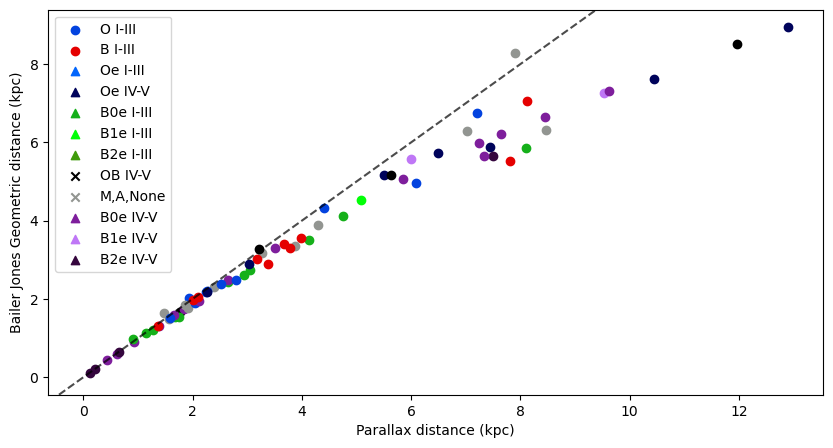

In [40]:
def comp_distances(table):
    prlx_mask = table['parallax']/table['parallax_error'] >=5.0
    table = table[prlx_mask] 
    dist_para = table['distance_para']
    dist_bj = table['distance_bj']
    mod_sptype = table['Mod_SpType']
    fig, axs = plt.subplots(figsize=(10,5))

    axs.axline((0, 0), slope=1,color='k',alpha=0.7,ls='--')
    for d, d_bj, sp_type, in zip(dist_para,dist_bj,mod_sptype):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        marker = marker_map.get(color, 'x') # Default marker for othersDefault marker for other
        axs.scatter(d,d_bj,color=color)
    for color, label in color_map.items():
        marker = marker_map.get(color,'x')
        axs.scatter([], [], color=color, label=label,marker=marker)

    plt.legend()
    plt.xlabel("Parallax distance (kpc)")
    plt.ylabel("Bailer Jones Geometric distance (kpc)")
    fig.savefig(home_files+'/Figures/'+f'Distance_comp_{today}.png')
    plt.show()
    return None
comp_distances(HMXB_table)

In [ ]:
def plot_peculiar(table):
    '''OUTDATED'''
    #large_mask = table['Peculiar Velocity'] <= 400
   # table = table[large_mask]
    v_thres = 40 #km/s threshold peculiar velocity
    prlx_mask = table['parallax']/table['parallax_error'] >=5.0
    table = table[prlx_mask] 
    
    V_pec = table['Peculiar Velocity']
    long = table['l']
    color = table['SpColor']
    

    fig, axs = plt.subplots(1,2, figsize=(15,8))
    for long_data, V_pec_data, color in zip(long, V_pec, color):
        axs[0].scatter(long_data, V_pec_data,c=color)
    axs[0].scatter([], [], color='blue', label='O')
    axs[0].scatter([], [], color='green', label='Be')
    axs[0].scatter([], [], color='red', label='B')

    axs[0].set_xlabel('Longitude (deg)')
    axs[0].set_ylabel("Peculiar Tangental Velocity")
    axs[0].axhline(y=v_thres,color='tab:orange')
    axs[0].legend(title='Spectral Type')
    #axs[0].set_ylim(-200,200)

    #histrogram
    # Filter V_pec values based on star types
    blue_mask = table['SpColor'] == 'blue'
    red_mask = table['SpColor'] == 'red'
    green_mask = table['SpColor'] == 'green'
    
    V_pec_O = table['Peculiar Velocity'][blue_mask]
    V_pec_Be = table['Peculiar Velocity'][green_mask]
    V_pec_B =  table['Peculiar Velocity'][red_mask]
    #print(len(V_pec_O),len(V_pec_Be),len(V_pec_B))
    # Histogram for V_pec based on star type
    bin_size = 10
    axs[1].hist(V_pec_O, bins=bin_size,  alpha=0.5, edgecolor='black', color='blue', label='O')
    axs[1].hist(V_pec_Be, bins=bin_size, alpha=0.4, edgecolor='black', color='green', label='Be')
    axs[1].hist(V_pec_B, bins= bin_size, alpha=0.5, edgecolor='black', color='red', label='B')
    
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel('Peculiar Tangential Velocity')
    axs[1].legend(title="Spectral Type")

   # fig.colorbar(v_pec_plot,label='bp_rp')
    return None
#plot_peculiar(HMXB_table)

In [41]:
max_vpec_mask =HMXB_table['Peculiar Velocity'].argmax()
max_vpec_data = HMXB_table[max_vpec_mask]
max_vpec_data

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
5943166184173519744,250.46160612338068,1.3305343,-45.540403360519775,0.65422994,-8.551346793903136,1.7982253,-5.318919221188635,1.1888338,0.9562030181651716,1.0759587,--,--,20.419172,339.18890175141337,0.4889589642760968,1.2369748,6.3262095,4.941406,8.815772,--,--,--,--,--,--,--,--,--,--,--,1.0458030156805707,-9.624728946911002,2.963279664429394,3.4267652084572333,215.45928957146128,-189.11090261685138,-0.5519134138549242,-0.2519424745936336,-5.3281225248164805,-3.390904694756337,0.03293263417729705,-46.650196933121,195.2817074300098,--,-5.681910838299741,3.1822895048457305,--,1.176780309139686,BN0.5Ia,xkcd:red,xkcd:red


9


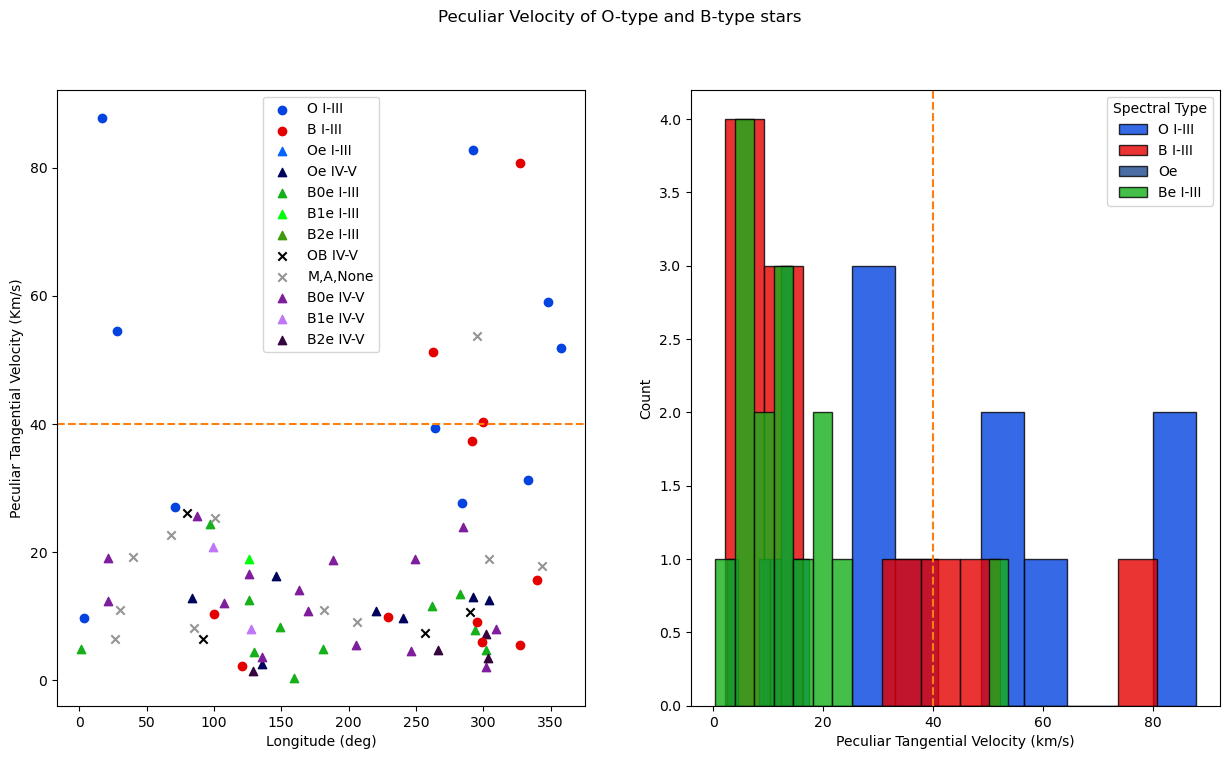

In [42]:

def plot_peculiar2(table,figname):
    prlx_mask = table['parallax']/table['parallax_error'] >=5.0
    table = table[prlx_mask] 
    
    V_pec = table['Peculiar Velocity']
    #V_pec = table['Peculiar Velocity']
    longitudes = table['l']
    mod_sptype = table['Mod_SpType']
    v_thres = 40  # km/s threshold peculiar velocity

    pec_mu_l = table['peculiar_mu_l']
    pec_mu_b = table['peculiar_mu_b']
    #Define a dictionary for color mapping


    # Plot scatter plot with colors based on Mod_SpType
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    
    for lon, vel, sp_type, pec_l, pec_b in zip(longitudes, V_pec, mod_sptype,pec_mu_l,pec_mu_b):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        marker = marker_map.get(sp_type, 'x') # Default marker for othersDefault marker for others
        axs[0].scatter(lon, vel, c=color,marker=marker)
        #axs[0].quiver([lon,vel],pec_l, pec_b,color='xkcd:black',angles='uv')
    
    # Add legend based on the color map
    for color, label in color_map.items():
        marker = marker_map.get(color,'x')
        axs[0].scatter([], [], color=color, label=label,marker=marker)
    
    axs[0].set_xlabel('Longitude (deg)')
    axs[0].set_ylabel("Peculiar Tangential Velocity (Km/s)")
    axs[0].axhline(y=v_thres, color='tab:orange', linestyle='--')
    axs[1].axvline(x=v_thres, color= 'tab:orange',linestyle='--')
    axs[0].legend()

    # Histogram of V_pec
    # Histogram for each group

    # Iterate over each group, filter, and plot
    for label, types, color in groups:
        V_pec_group = [vel for vel, sp_type in zip(V_pec, mod_sptype) if sp_type in types]
        
        if V_pec_group:
            vmin, vmax = np.min(V_pec_group), np.max(V_pec_group)
            bins = np.linspace(vmin, vmax,len(V_pec_group)+1)
            axs[1].hist(V_pec_group, bins=bins, alpha=0.8, edgecolor='black', color=color, label=label)
            axs[1].legend()

    axs[1].set_ylabel("Count")
    axs[1].set_xlabel('Peculiar Tangential Velocity (km/s)')
    axs[1].legend(title="Spectral Type")
    # add arrows
    
    fig.suptitle("Peculiar Velocity of O-type and B-type stars")
    fig.savefig(home_files+'/Figures/'+f'{figname}_{today}.png')
    print(len(table[table['Peculiar Velocity'] >=v_thres]))
    
    return None
plot_peculiar2(HMXB_table,'Peculiar_Velocity')

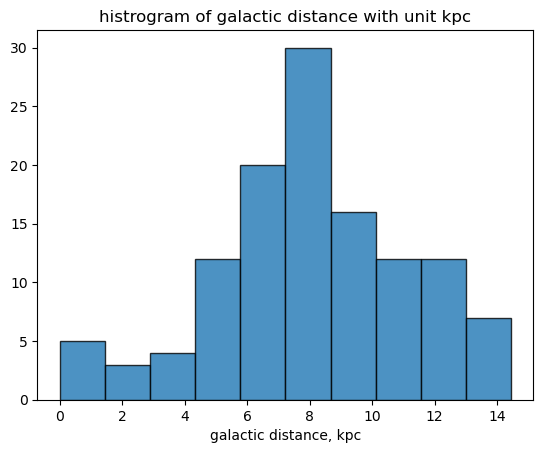

Unit("kpc")

In [43]:
#make a histogram
def plot_hist(table,param):
    unit = table[param].unit
    title = f'histrogram of {param} with unit {unit}'
    
    data = table[param]
    bins = np.linspace(data[0], data[-1]).sort()
    plt.title(title)
    plt.hist(data,bins=bins,alpha=0.8,edgecolor='black')
    plt.xlabel(f'{param}, {unit}')
    plt.show()
    return table[param].unit
plot_hist(HMXB_table,'galactic distance')

76


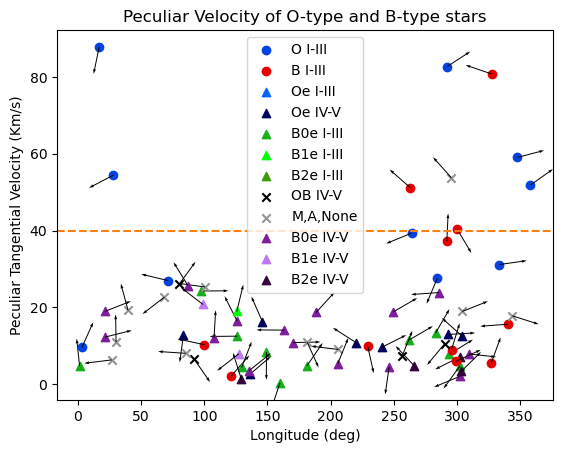

In [45]:
def plot_arrows(table):
    prlx_mask = table['parallax']/table['parallax_error'] >=5.0
    table = table[prlx_mask] 
    print(len(table))
    V_pec = table['Peculiar Velocity']
    #V_pec = table['Peculiar Velocity']
    longitudes = table['l']
    mod_sptype = table['Mod_SpType']
    v_thres = 40  # km/s threshold peculiar velocity

    pec_mu_l = table['peculiar_mu_l']
    pec_mu_b = table['peculiar_mu_b']
    #Define a dictionary for color mapping


    # Plot scatter plot with colors based on Mod_SpType
    #fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    
    for lon, vel, sp_type, pec_l, pec_b in zip(longitudes, V_pec, mod_sptype,pec_mu_l,pec_mu_b):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        marker = marker_map.get(sp_type, 'x') # Default marker for othersDefault marker for others
        plt.scatter(lon, vel, c=color,marker=marker)
        plt.quiver(lon,vel,pec_l, pec_b,color='xkcd:black',angles='uv',width=0.002)
    
    # Add legend based on the color map
    for color, label in color_map.items():
        marker = marker_map.get(color,'x')
        plt.scatter([], [], color=color, label=label,marker=marker)
    
    plt.xlabel('Longitude (deg)')
    plt.ylabel("Peculiar Tangential Velocity (Km/s)")
    plt.axhline(y=v_thres, color='tab:orange', linestyle='--')
    plt.legend()


    plt.title("Peculiar Velocity of O-type and B-type stars")
    plt.savefig(home_files+'/Figures/'+f'arrows_{today}.png')
    # plt.show()
    
    return None
plot_arrows(HMXB_table)

# Mask negative Parallax

In [46]:
mask = HMXB_table['Peculiar Velocity'] <= 400
non_neg_HMXB_table = HMXB_table[mask]
#negative_mask = non_neg_HMXB_table["Peculiar Velocity"] >= 0
#non_neg_HMXB_table = non_neg_HMXB_table[negative_mask]

9


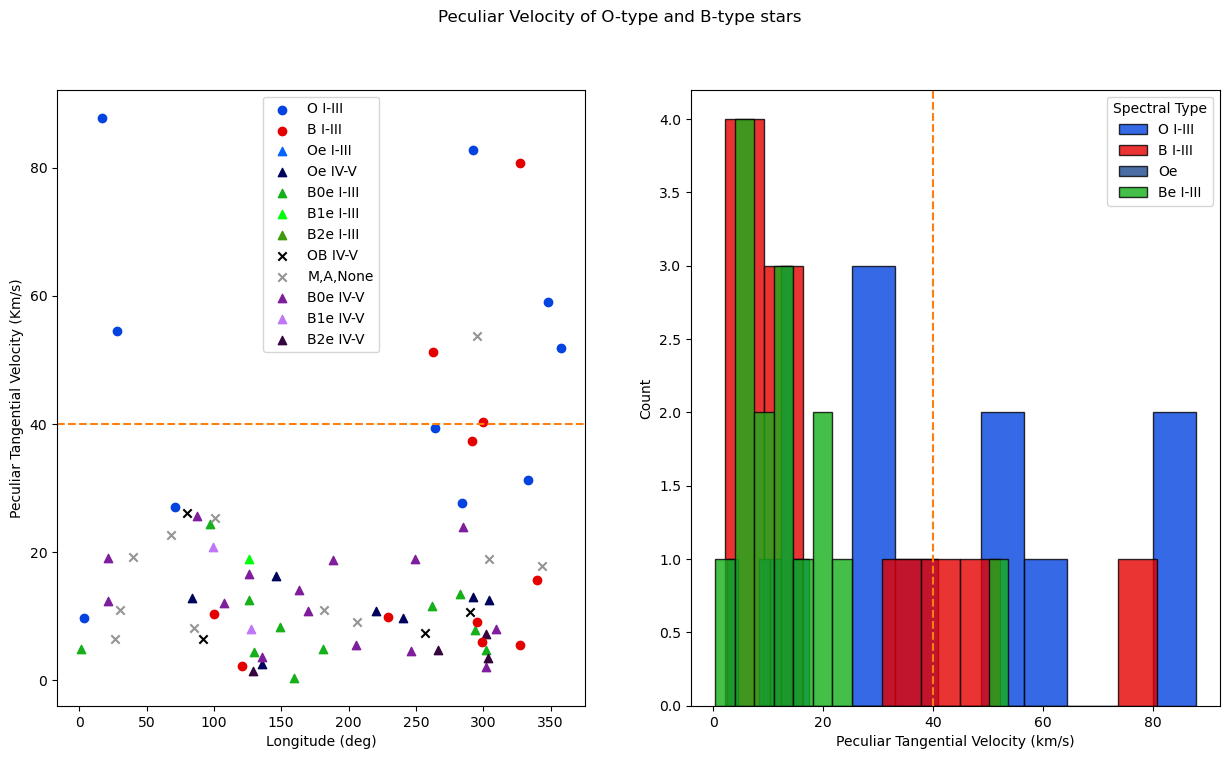

In [47]:
len(non_neg_HMXB_table)
plot_peculiar2(non_neg_HMXB_table,'Peculiar_velocity_slow')

(array([ 8., 16., 20., 10.,  1.,  4.,  2.,  1.,  1.,  2.]),
 array([ 7.8 , 11.62, 15.44, 19.26, 23.08, 26.9 , 30.72, 34.54, 38.36,
        42.18, 46.  ]),
 <BarContainer object of 10 artists>)

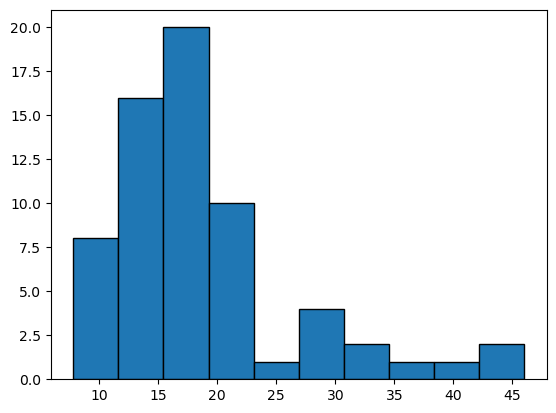

In [48]:
plt.hist(HMXB_table['Mo'],edgecolor='k')

76 76


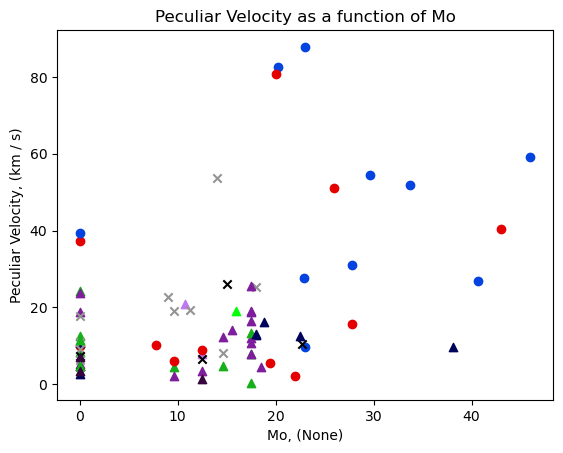

In [49]:
def plot_something(table,x_param, y_param):
    
    prlx_mask = table['parallax']/table['parallax_error'] >=5.0
    table = table[prlx_mask] 
    
    x = table[x_param]
    y = table[y_param]
    gmag = table['phot_g_mean_mag']
    mod_sptype = table['Mod_SpType']
    x_name = str(x_param)
    y_name = str(y_param)
    x_unit = x.unit
    y_unit = y.unit
    print(len(y),len(x))
    for xi, yi, sp_type, in zip(np.array(x), np.array(y), mod_sptype):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        marker = marker_map.get(sp_type, 'x') # Default marker for othersDefault marker for others
        figure = plt.scatter(xi, yi, c=color,marker=marker)
    
    #figure = plt.scatter(x,y,c=gmag,cmap='seismic')
    #plt.colorbar(figure,label='Gmag')
    plt.xlabel(f"{x_name}, ({x_unit})")
    plt.ylabel(f"{y_name}, ({y_unit})")
    plt.title(f"{y_name} as a function of {x_name}")
    
    return None
plot_something(HMXB_table,'Mo','Peculiar Velocity')

In [50]:
nomass = HMXB_table['source_id','Mo']
vicam = HMXB_table[HMXB_table['source_id'] == 276644757710014976]
vicam

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.21955319252043,226.44694446947207,79.40436769858293,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.85185815500798,0.1263796031088879,-49.20037366231826,8.330736058162561,-3.551804106252541,-0.0010547363810687882,-0.42571977562840535,9.056294809686923,0.3367754452749184,B1/2I[e],xkcd:green,xkcd:green


In [51]:
negative_parallax_mask = HMXB_table['parallax'] <=0
negative_parallax = HMXB_table[negative_parallax_mask]
negative_parallax_ID = negative_parallax['source_id']
str_negative_parallax = ','.join(map(str,negative_parallax_ID))
str_negative_parallax

'426558460884582016,4070968778561141760,4156747212545110400,4256500538116700160,4310118570535453696,4512787627579740032,5882543824607819776,5883218164517055488,5940576971716473344,5940777877435137024'

# Folloiwing Bailler Jones GAIA Dr3

https://dc.zah.uni-heidelberg.de/__system__/adql/query/form

These are sources with negative parallax
17 sources became 8

SELECT source_id, r_med_geo
FROM gedr3dist.main
 JOIN gaia.edr3lite USING(source_id)
WHERE source_id in (2028089540103670144,2070085317968809216,4040960662373474176,4070968778561141760,4256500538116700160,4306419980916246656,4309253392325650176,4310118570535453696,4310649153642824320,4512787627579740032,5854175187680510336,5882543824607819776,5883218164517055488,5934776158877214848,5940576971716473344,5940777877435137024,5980409632300781056)

# Exporting table

In [52]:
HMXB_table.write(csv_files+"HMXB_practice_analysis_0101.csv",format='csv',overwrite=True)

#export with units
HMXB_table.write(csv_files+'HMXB_practice_analysis.ecsv', format='ascii.ecsv',overwrite=True)

In [53]:
psrb1 = HMXB_table[ (HMXB_table['SpColor'] == "xkcd:blue") & (HMXB_table['Period'] > 1000)]
psrb1

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
5862299960127967488,195.69848851536304,0.008934321,-63.83573123376698,0.009974834,-7.092820662863646,0.011759594,-0.34195092640087815,0.014234628,0.44344477764993895,0.013309076,--,--,9.632835,304.18354481654586,-0.9915822428813386,0.981228,2.1670405,2.112464,2.2226743,PSR B1259-63,--,--,22.5,7.5,0.0,1.0,1236.724526,6e-06,0.04776,--,2.255072221843625,-7.100960208667895,0.037409978977678573,7.499968850861359,222.16321966788368,-206.48115822869718,-1.6136764384742552,-0.7310496310826367,5.313301714392077,-4.5837197782546575,-0.04088352819180947,-21.408429113923958,12.460062485893731,16.095127399531883,-0.9035639919389826,0.8093431382521248,20.354515055867537,0.06768132147403795,O9.5Ve,xkcd:dark blue,xkcd:blue


In [54]:
# verify_pipeline = pipeline('GAIA_HMXB_DNE.ecsv', fmt='ecsv')
# verify_table = verify_pipeline.lay_pipe(filename='HMXB_with_analysis.ecsv',filetype='ascii.ecsv')

In [55]:
#HD153919_read = ascii.read("HD153919-result.ecsv",format='ecsv')
# verify_pipeline = pipeline(home_files+'HD153919-result.ecsv',fmt='ecsv')
# HD153919= verify_pipeline.lay_pipe(filename=home_files+'HD153919-result.ecsv',filetype='ascii.ecsv')

In [56]:
# HD153919


In [57]:
# HD3879_pipeline = pipeline(home_files+'HD 36879-result.ecsv',fmt='ecsv')
# HD3879 =  HD3879_pipeline.lay_pipe(filename=home_files+'HD 36879.ecsv',filetype='ascii.ecsv')
# HD3879

In [58]:
# HD153919['name'] = 'HD153919'
# HD3879['name']= 'HD36879'
# HD153919['name'].value[0]

In [59]:
# HMXB_table = ascii.read('HMXB_20241105_.csv',format='csv')
# HMXB_table

In [60]:
def plot_comparison(table, other_stars,figname):
    large_mask = table['Peculiar Velocity'] <= 400
    table = table[large_mask]
    negative_mask = table['Peculiar Velocity'] >= 0
    table = table[negative_mask]
    prlx_mask = table['parallax']/table['parallax_error'] >=5.0
    table = table[prlx_mask] 
    V_pec = table['Peculiar Velocity']
    long = table['l']
    color = table['SpColor']
    mod_sptype = table['Mod_SpType']
    v_thres = 40 #km/s threshold peculiar velocity
    #mask large ass values in the table
    # large_mask = table['Peculiar Velocity'] <= 400
    # table = table[large_mask]
    other_color = 'c'
    fig, axs = plt.subplots(1,2, figsize=(15,8))
    for i, star in enumerate(other_stars):
        star_v_pec = star['Peculiar Velocity']
        star_long = star['l']
        star_name = str(star['name'].value[0])
        axs[0].scatter(star_long,star_v_pec,c=other_color)
        axs[0].annotate(f'{star_name}',(star_long,star_v_pec))
    for long_data, V_pec_data, color in zip(long, V_pec, color):
        axs[0].scatter(long_data, V_pec_data,c=color)
    axs[0].scatter([], [], color='blue', label='O')
    axs[0].scatter([], [], color='green', label='Be')
    axs[0].scatter([], [], color='red', label='B')

    axs[0].set_xlabel('Longitude (deg)')
    axs[0].set_ylabel("Peculiar Tangental Velocity")
    axs[0].axhline(y=v_thres,color='tab:orange')
    axs[0].legend(title='Spectral Type')
    #axs[0].set_ylim(-200,200)

    #histrogram
    # Filter V_pec values based on star types
    blue_mask = table['SpColor'] == 'blue'
    red_mask = table['SpColor'] == 'red'
    green_mask = table['SpColor'] == 'green'
    
    V_pec_O = table['Peculiar Velocity'][blue_mask]
    V_pec_Be = table['Peculiar Velocity'][green_mask]
    V_pec_B =  table['Peculiar Velocity'][red_mask]
    #print(len(V_pec_O),len(V_pec_Be),len(V_pec_B))
    # Histogram for V_pec based on star type
    bin_size = 10
    for label, types, color in groups:
        V_pec_group = [vel for vel, sp_type in zip(V_pec, mod_sptype) if sp_type in types]
        
        if V_pec_group:
            bins = np.linspace(V_pec_group[0], V_pec_group[-1]).sort()
            axs[1].hist(V_pec_group, bins=bins, alpha=0.8, edgecolor='black', color=color, label=label)
            axs[1].legend()
    axs[0].axhline(y=v_thres, color='tab:orange', linestyle='--')
    axs[1].axvline(x=v_thres, color= 'tab:orange',linestyle='--')
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel('Peculiar Tangential Velocity')
    axs[1].legend(title="Spectral Type")
    fig.suptitle("Verification of Peculiar Velocity with known sources")
    fig.savefig(home_files+'/Figures/'+f'{figname}_{today}.png')
    plt.show()
    return None
# list_of_comp_stars = [HD153919, HD3879]
# plot_comparison(HMXB_table, list_of_comp_stars,'Verification')

In [61]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
def plot_galactic_map(table,other_stars):
    ''''''
    mod_sptype = table['Mod_SpType']

    gal_l , gal_b= table['l'],table['b']
    
    fig, ax  = plt.subplots(1,figsize=(10,4))
    blue_mask = table['SpColor'] == 'blue'
    red_mask = table['SpColor'] == 'red'
    green_mask = table['SpColor'] == 'green'
    
    l_pec_O = table['l'][blue_mask]
    l_pec_Be = table['l'][green_mask]
    l_pec_B =  table['l'][red_mask]

    b_pec_O = table['b'][blue_mask]
    b_pec_Be = table['b'][green_mask]
    b_pec_B =  table['b'][red_mask]

    #check with HD153919

    plt.axis('off')
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='aitoff')
    for long, lat, sp_type in zip(gal_l, gal_b, mod_sptype):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        #axs[0].scatter(gal_l,gal_b, c=color)
        marker = marker_map.get(sp_type, 'x') 
        ax.scatter(np.radians(long*180), np.radians(lat),c=color,marker=marker)
    for color, label in color_map.items():
        marker= marker_map.get(color, 'x') 
        ax.scatter([], [], color=color, label=label,marker=marker)

    plt.legend(title='Spectral Type',loc='center left',bbox_to_anchor= (1.04,0.5))
    
    #Set labels for axes
    plt.xlabel('Galactic Longitude (degrees)')
    plt.ylabel('Galactic Latitude (degrees)')
    fig.savefig(home_files+'/Figures/'+f'Galaxy_map_{today}.png')
    ax.grid(True)
    plt.show()
#plot_galactic_map(HMXB_table,list_of_comp_stars)   

In [62]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
def plot_galactic_map_with_background(table):
    ''''''
    mod_sptype = table['Mod_SpType']

    gal_l , gal_b= table['l'],table['b']
    
    fig, ax  = plt.subplots(1,figsize=(10,4))
    blue_mask = table['SpColor'] == 'blue'
    red_mask = table['SpColor'] == 'red'
    green_mask = table['SpColor'] == 'green'
    
    l_pec_O = table['l'][blue_mask]
    l_pec_Be = table['l'][green_mask]
    l_pec_B =  table['l'][red_mask]

    b_pec_O = table['b'][blue_mask]
    b_pec_Be = table['b'][green_mask]
    b_pec_B =  table['b'][red_mask]

    #check with HD153919

    plt.axis('off')
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='aitoff')
    for long, lat, sp_type in zip(gal_l, gal_b, mod_sptype):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        #axs[0].scatter(gal_l,gal_b, c=color)
        marker = marker_map.get(sp_type, 'x') 
        ax.scatter(np.radians(long*180), np.radians(lat),c=color,marker=marker)
    for color, label in color_map.items():
        marker= marker_map.get(color, 'x') 
        ax.scatter([], [], color=color, label=label,marker=marker)

    plt.legend(title='Spectral Type',loc='center left',bbox_to_anchor= (1.04,0.5))
    
    #Set labels for axes
    plt.xlabel('Galactic Longitude (degrees)')
    plt.ylabel('Galactic Latitude (degrees)')
    fig.savefig(home_files+'/Figures/'+f'Galaxy_map_{today}.png')
    ax.grid(True)
    plt.show()

In [63]:
HMXB_table

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.050221459400962,223.80233108648486,57.85735769631713,5.678754520826265,-1.8927588919495255,8.331080353841104,-0.42115497748487507,-0.4031590737758587,-3.960352607991092,14.076316148409987,-3.3707277458500116,-4.948010566375453,0.05059403150657038,14.47426964812494,0.014142822981115537,B0Ve,xkcd:purple,xkcd:green
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.802540754166134,224.50262725968088,33.25228004590941,2.439435356227649,-1.2311682821565653,8.193677748526671,-0.13190006446789362,0.010006155364788641,-5.822783384310856,10.831623641291293,-22.870894364215815,1.730886740460443,0.04223719346436274,25.306162880328166,0.05783159604211228,B0 IVpe,xkcd:purple,xkcd:green
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5,2.639752590095405,0.9593255549561471,-0.7047859211231655,10.826248319671492,225.3768378268218,60.209536638138864,1.4234979660475775,-0.64554297906578,5.620332737130843,-0.4548931277874611,-0.031164453762589747,-20.73843455429136,0.3425304843913022,--,-0.009279283303969266,-0.028078488294795815,--,0.10482196429390027,B0e,xkcd:green,xkcd:green
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.21955319252043,226.44694446947207,79.40436769858293,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.85185815500798,0.1263796031088879,-49.20037366231826,8.330736058162561,-3.551804106252541,-0.0010547363810687882,-0.42571977562840535,9.056294809686923,0.3367754452749184,B1/2I[e],xkcd:green,xkcd:green
41419

In [64]:
ss433 = HMXB_table['Name'] == 'SS 433'
ss433 = HMXB_table[ss433]

In [65]:
ss433

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
4293406612283985024,287.9565063699124,0.01839638,4.982708527256882,0.018368214,-3.0269258944121806,0.023585632,-4.776844591679762,0.023861438,0.11817711247763943,0.023269137,--,--,12.602749,39.69407310529392,-2.244594208819768,1.2414011,6.3208223,5.5387407,7.907363999999999,SS 433,4.2,0.4,11.3,0.6,69.0,4.7,13.08,0.0,--,--,8.461875392235635,-5.637365080515104,0.4479280883268187,5.433489206866043,219.37950661562388,217.65395946626057,-0.11905262505945725,-0.27568922475721885,-16.68568981131006,-5.350880591268805,0.10366435959265656,50.65284174909329,19.23969292825361,35.03284806221677,-0.16743186418684175,0.619952953491381,39.96831529253963,1.6661478416707238,A3-7 I,xkcd:grey,xkcd:grey


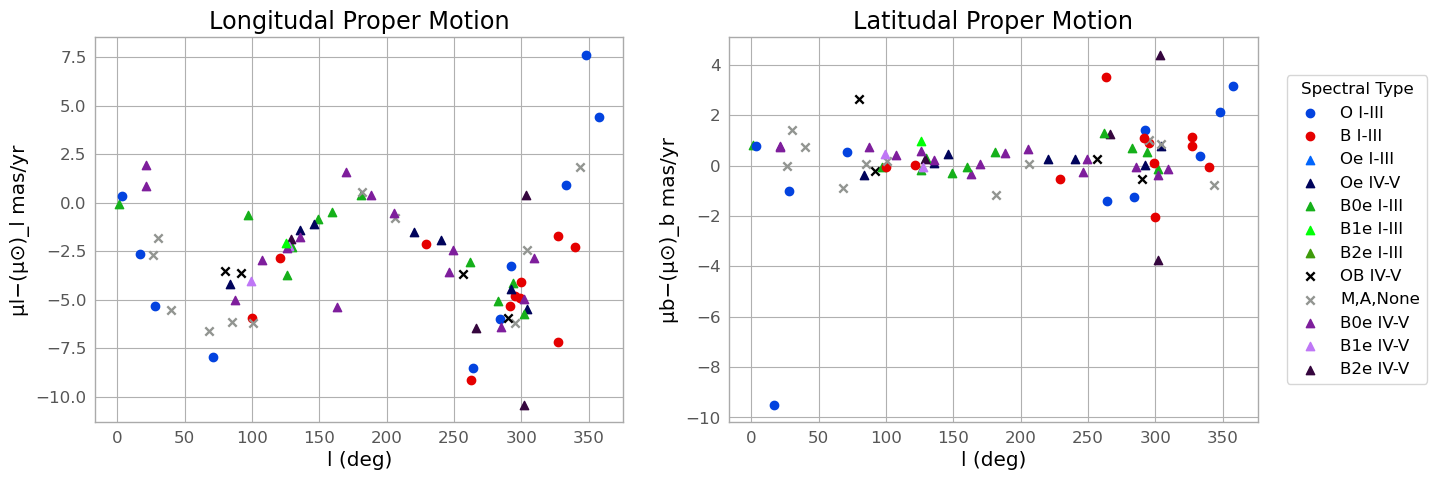

In [66]:
def plot_pm(table):
    prlx_mask = table['parallax']/table['parallax_error'] >=5.0
    table = table[prlx_mask] 
    
    long = table['l']
    pm_l = table['pm_l_poleski']
    pm_b = table['pm_b_poleski']
    sol_l = table['mu_l_sol']
    sol_b = table['mu_b_sol']
    mod_sptype = table['Mod_SpType']

    corrected_pml = pm_l - sol_l
    corrected_pmb = pm_b - sol_b
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns
    
    for l,pml, sp_type in zip(long, corrected_pml,mod_sptype):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        #axs[0].scatter(gal_l,gal_b, c=color)
        marker = marker_map.get(sp_type, 'x') 
        axs[0].scatter(l,pml,c=color,marker=marker)
        axs[0].set_title('Longitudal Proper Motion')
        axs[0].set_xlabel('l (deg)')
        axs[0].set_ylabel(r'μl−(μ⊙)_l mas/yr')
    for l,pmb, sp_type in zip(long, corrected_pmb,mod_sptype):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        #axs[0].scatter(gal_l,gal_b, c=color)
        marker = marker_map.get(sp_type, 'x') 
        axs[1].scatter(l,pmb,c=color,marker=marker)
        axs[1].set_title('Latitudal Proper Motion')
        axs[1].set_xlabel('l (deg)')
        axs[1].set_ylabel(r'μb−(μ⊙)_b mas/yr')
    
    for color, label in color_map.items():
        marker= marker_map.get(color, 'x') 
        plt.scatter([], [], color=color, label=label,marker=marker)

    plt.legend(title='Spectral Type',loc='center left',bbox_to_anchor= (1.04,0.5))
    plt.savefig(home_files+'/Figures/'+f'Solar_PM_{today}.png')
    
        
    return None
plot_pm(HMXB_table)

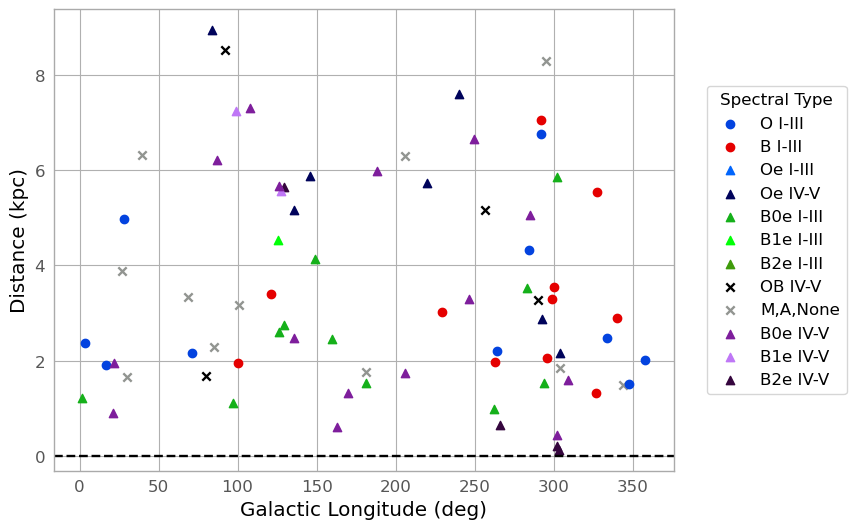

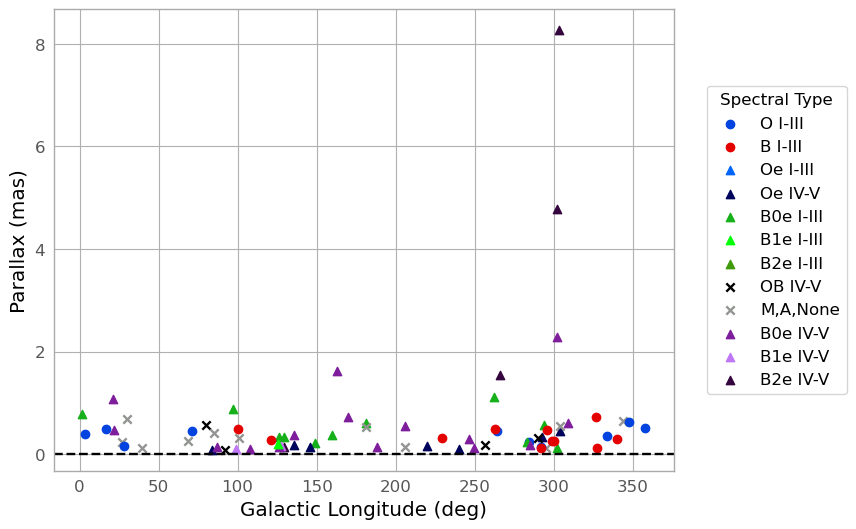

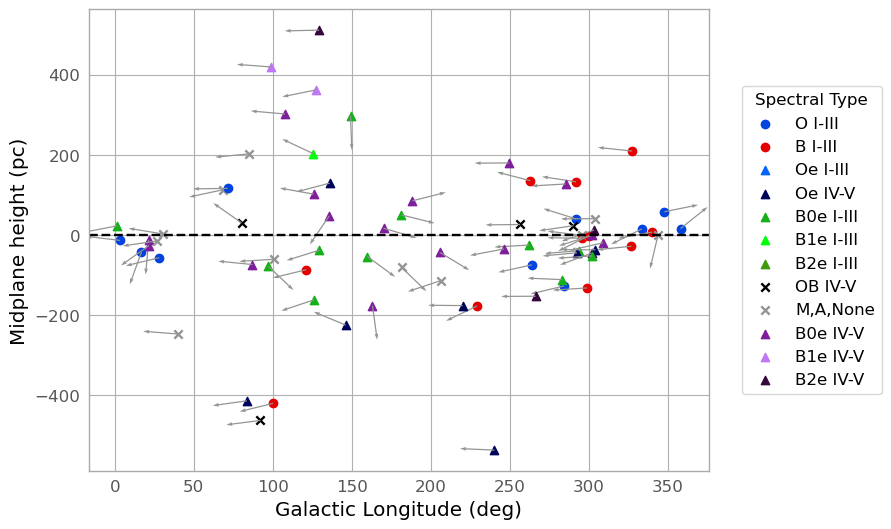

In [68]:
def plot_distances(table):
    '''OUTDATED proper motion arrows are wrong
    
    angle = xy is correct
    Need to do alot of work to fix it, cant be asked yet'''
    prlx_mask = table['parallax']/table['parallax_error'] >=5.0
    table = table[prlx_mask]
    parallax =table['parallax']
    dist = table['distance_bj']
    long = table['l']
    lat = table['b']
    pec_mu_l = table['peculiar_mu_l']
    pec_mu_b = table['peculiar_mu_b']
    height = dist*np.sin(np.radians(lat))
    #also add peculiar vector
    pm_mu_l = table['pm_l_poleski']
    pm_mu_b = table['pm_b_poleski']
    mod_sptype = table['Mod_SpType']

    #distance  
    for l,d, sp_type in zip(long,dist, mod_sptype):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        #axs[0].scatter(gal_l,gal_b, c=color)
        marker = marker_map.get(sp_type, 'x') 
        plt.scatter(l,d,c=color,marker=marker)
    for color, label in color_map.items():
        marker= marker_map.get(color, 'x') 
        plt.scatter([], [], color=color, label=label,marker=marker)
    plt.legend(title='Spectral Type',loc='center left',bbox_to_anchor= (1.04,0.5))
    plt.axhline(y=0, color= 'xkcd:black',linestyle='--')
    plt.xlabel('Galactic Longitude (deg)')
    plt.ylabel('Distance (kpc)')
    plt.savefig(home_files+"/Figures/"+f"distance_{today}.png",bbox_inches='tight')
    plt.show()

    #parllax 
    for l,p, sp_type in zip(long,parallax, mod_sptype):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        #axs[0].scatter(gal_l,gal_b, c=color)
        marker = marker_map.get(sp_type, 'x') 
        plt.scatter(l,p,c=color,marker=marker)# Import Data

    for color, label in color_map.items():
        marker= marker_map.get(color, 'x') 
        plt.scatter([], [], color=color, label=label,marker=marker)
    lgd = plt.legend(title='Spectral Type',loc='center left',bbox_to_anchor= (1.04,0.5))
    plt.axhline(y=0, color= 'xkcd:black',linestyle='--')
    plt.xlabel('Galactic Longitude (deg)')
    plt.ylabel('Parallax (mas)')
    #plt.tight_layout()
    plt.savefig(home_files+"/Figures/"+f"parallax_{today}.png",bbox_inches='tight')
    plt.show()
    # height
    
    for l,z, sp_type, pec_l, pec_b,pm_l,pm_b,d in zip(long,height, mod_sptype,pec_mu_l,pec_mu_b,pm_mu_l,pm_mu_b,dist):
        color = sp_type if sp_type in color_map else 'xkcd:grey'
        marker = marker_map.get(sp_type, 'x') 
        #kpc to pc
        plt.scatter(l,z*1000,c=color,marker=marker)
        #peciliar
        #plt.quiver(l,z*1000,pec_l, pec_b,color='xkcd:black',angles='uv',width=0.002)
        #observed
        #pm_z = d*np.radians()
        plt.quiver(l,z*1000, pm_l, pm_b, color='xkcd:grey',angles='uv',width=0.002)
    for color, label in color_map.items():
        marker= marker_map.get(color, 'x') 
        plt.scatter([], [], color=color, label=label,marker=marker)
    plt.legend(title='Spectral Type',loc='center left',bbox_to_anchor= (1.04,0.5))
    plt.axhline(y=0, color= 'xkcd:black',linestyle='--')
    plt.xlabel('Galactic Longitude (deg)')
    plt.ylabel('Midplane height (pc)')
    plt.savefig(home_files+"/Figures/"+f"height_{today}.png",bbox_inches='tight')
    plt.show()

    
    return None
plot_distances(HMXB_table)
    


/tmp/ipykernel_42629/4200312123.py:36: UserWarning: Warning: converting a masked element to nan.
  pm_theta_list = np.array(pm_theta_list)
/tmp/ipykernel_42629/4200312123.py:37: UserWarning: Warning: converting a masked element to nan.
  pec_theta_list = np.array(pec_theta_list)


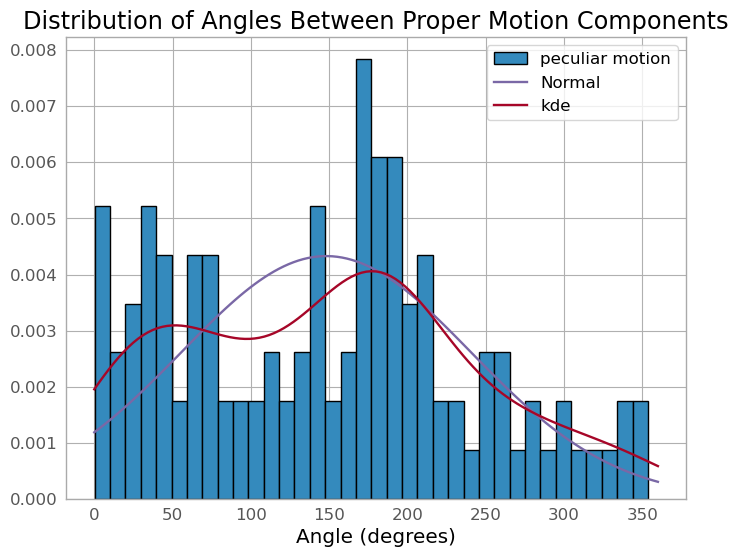

In [69]:
from scipy import stats
def bimodal(x,sigma):
    return None
def make_angle_distribution(table):
    #peculiar motion
    pec_mu_l = table['peculiar_mu_l']
    pec_mu_b = table['peculiar_mu_b']

    #proper motion
    pm_b = table['pm_b_poleski']
    pm_l = table['pm_l_poleski']
    
    pm_theta = np.arctan2(pm_b,pm_l) #radians
    pm_theta = np.degrees(pm_theta)
    pm_theta_list = []
    
    for deg in pm_theta:
        if deg <0:
            deg += 360
        pm_theta_list.append(deg)

    
    pec_theta = np.arctan2(pec_mu_b,pec_mu_l) #radians
    pec_theta = np.degrees(pec_theta)
    pec_theta_list = []

    for deg in pec_theta:
        if deg <0:
            deg += 360
        pec_theta_list.append(deg)
    #degrees per bin
    degbins = 10
    n_bins = 360/degbins

    #convert to numpy array
    pm_theta_list = np.array(pm_theta_list)
    pec_theta_list = np.array(pec_theta_list)
    
    #mask nans
    pec_theta_list = pec_theta_list[~np.isnan(pec_theta_list)]
    pm_theta_list = pm_theta_list[~np.isnan(pm_theta_list)]
    plt.hist(pec_theta_list, bins=int(n_bins), edgecolor='black',label='peculiar motion',density=True)

    #make a model fit
    xt = plt.xticks()[0]  
    xmin, xmax = 0, 360
    lnspc = np.linspace(xmin, xmax, len(pec_theta_list))
    mean, std = np.nanmean(pec_theta_list), np.nanstd(pec_theta_list)
    pec_norm_pdf= stats.norm.pdf(lnspc, mean,std)
    
    pec_kde_pdf = stats.gaussian_kde(pec_theta_list)
    kde_vals = pec_kde_pdf(lnspc)
    
    plt.plot(lnspc,pec_norm_pdf,label='Normal')
    plt.plot(lnspc, kde_vals,label='kde')
    #plt.hist(pm_theta_list, bins=int(n_bins), edgecolor='black', alpha=0.8,label='Proper motion',density=True)
    plt.legend()
    
    plt.xlabel('Angle (degrees)')
    #plt.ylabel('Frequency')
    plt.title('Distribution of Angles Between Proper Motion Components')
    plt.show()
        
    return pm_theta
x= make_angle_distribution(HMXB_table)

# Find missing grey stars

In [70]:
grey_stars_mask = HMXB_table['Mod_SpType'] == 'xkcd:grey'
grey_stars = HMXB_table[grey_stars_mask]
grey_stars

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
2034031438383765760,298.92639832142635,0.016134035,32.096930318736355,0.021289147,-2.158047594075068,0.020837534,-6.0711257533713265,0.025808768,0.2575299882811361,0.024460983,4.7357154,0.5058494,8.358267,68.39194055158187,1.9268933031575586,0.9647663,3.3417725000000003,3.1170286000000003,3.59347,4U 1954+319,--,--,9.0,4.0,--,--,1296.6375,--,18612.0,--,3.883042928997987,-6.299409845170768,-1.3539471681374267,7.905441982386948,222.62132477028115,220.42237918393607,0.3177243449250364,-0.4442435931714961,-16.86755941286106,-5.486198170414174,-0.032654502765199586,14.299034618494337,22.669645438255422,--,-1.1309360196816298,-0.877049072200731,--,0.36882324225034974,M4 I,xkcd:grey,xkcd:grey
4070770243676311936,269.64397104543735,0.27038908,-21.389332109203,0.19027168,-2.36538712986673,0.35116014,-3.810504961475337,0.23855187,0.133383862286102,0.22734681,--,--,18.813751,7.98621486794217,1.3265957398942791,1.2601464,5.991798,4.5084336,9.078527,--,--,--,--,--,--,--,--,--,--,--,7.497158823119456,-4.48255485892972,0.14733048650189942,2.6994005818957105,213.4580473110815,93.06139768197646,-0.421377867269656,-0.25726476071271764,-12.757347834417118,-0.7056766031673385,-0.05354033055505306,20.85313637435479,96.18412839593181,--,-3.3555003884927252,0.4581355777696701,--,12.77857078195223,--,xkcd:grey,xkcd:grey
4146789141900648576,271.1624089614886,0.23183206,-14.9464336382636,0.19731422,2.8163949695952675,0.32420734,0.5248669367618788,0.21428205,0.35637339844069704,0.25637776,--,--,19.099766,14.30687793079159,3.2517753399711236,0.9389223,3.9536619,2.7067759999999996,5.2580103,--,--,--,--,--,--,--,--,--,--,--,2.806045581335406,1.8355272451174276,-2.1996376198135343,4.775800645115384,218.27508864226965,95.31697515610968,-0.560787863938382,-0.36304064607054637,-14.234657675005737,-0.8336503099646971,-0.12832047740871774,23.78135278793313,68.47513544617489,--,3.2299654190205067,-1.7082764963342703,--,2.018690716522475,--,xkcd:grey,xkcd:grey
4156747212545110400,278.8576017596259,2.8617914,-7.614004545977431,2.1571057,--,--,--,--,--,--,--,--,20.38705,24.33602586714134,0.06569920978307321,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1.0,--,--,0.0,1.5664,inf,--,--,-15.453451310017302,--,--,nan,--,--,--,--,--,--,M5III-V,xkcd:grey,xkcd:grey
4259088994635370752,281.5533010323846,0.093761496,-2.3739097448759168,0.09704078,-1.6014907067769724,0.11734643,-2.1504326332738555,0.10132134,0.6764355935672552,0.12099661,--,--,17.650904,30.22372840554395,0.07923084081716135,0.9846449,1.6504329,1.3391590000000002,2.0476625,--,--,--,--,--,--,--,--,--,--,--,1.47833734580168,-2.6462259339821044,0.43199687552420307,7.122536420864109,221.7148897980028,132.10972793929787,-0.807207032557862,-0.9686272598460833,-16.188349840951997,-1.8170609532400093,-0.0037857984911944037,17.94

# Simbad Query

In [72]:
Simbad.add_votable_fields('sp_type')
grey_simbad =['GAIA DR3 ' + str(source_id) for source_id in grey_stars['source_id']]
grey_simbad

['GAIA DR3 2034031438383765760',
 'GAIA DR3 4070770243676311936',
 'GAIA DR3 4146789141900648576',
 'GAIA DR3 4156747212545110400',
 'GAIA DR3 4259088994635370752',
 'GAIA DR3 4293406612283985024',
 'GAIA DR3 5980409632300781056',
 'GAIA DR3 6054778507172454912']

# Run this twice, it works

In [73]:

# result_table = Simbad.query_objects(grey_simbad)
# result_table

In [74]:
#help(Simbad.add_votable_fields)
# import astroquery.simbad
# help(astroquery.simbad.SimbadClass.list_votable_fields)

In [75]:
#result_table.write(home_files+'Greystars_type.csv',format='ascii.csv',overwrite=True)

# Be Stars
Find all the Be stars and hopefully their spin periods

In [76]:
Bestars_color_mask =HMXB_table['SpColor'] =='xkcd:green'
Bestars = HMXB_table[Bestars_color_mask]
Bestars

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.050221459400962,223.80233108648486,57.85735769631713,5.678754520826265,-1.8927588919495255,8.331080353841104,-0.42115497748487507,-0.4031590737758587,-3.960352607991092,14.076316148409987,-3.3707277458500116,-4.948010566375453,0.05059403150657038,14.47426964812494,0.014142822981115537,B0Ve,xkcd:purple,xkcd:green
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.802540754166134,224.50262725968088,33.25228004590941,2.439435356227649,-1.2311682821565653,8.193677748526671,-0.13190006446789362,0.010006155364788641,-5.822783384310856,10.831623641291293,-22.870894364215815,1.730886740460443,0.04223719346436274,25.306162880328166,0.05783159604211228,B0 IVpe,xkcd:purple,xkcd:green
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5,2.639752590095405,0.9593255549561471,-0.7047859211231655,10.826248319671492,225.3768378268218,60.209536638138864,1.4234979660475775,-0.64554297906578,5.620332737130843,-0.4548931277874611,-0.031164453762589747,-20.73843455429136,0.3425304843913022,--,-0.009279283303969266,-0.028078488294795815,--,0.10482196429390027,B0e,xkcd:green,xkcd:green
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.21955319252043,226.44694446947207,79.40436769858293,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.85185815500798,0.1263796031088879,-49.20037366231826,8.330736058162561,-3.551804106252541,-0.0010547363810687882,-0.42571977562840535,9.056294809686923,0.3367754452749184,B1/2I[e],xkcd:green,xkcd:green
41419

In [77]:
Bestars_id = Table(Bestars['source_id'])
                   
#Bestars_id.write('Be_gaia_id.txt',format='ascii.no_header',overwrite=True)

In [78]:
Bestars_id_pandas = Bestars_id.to_pandas()

In [79]:
Bestars_id_pandas.values

array([[ 168450545792009600,  184497471323752064,  252878401557369088,
         276644757710014976,  414196617287885312,  426558460884582016,
         465645515129855872,  511220031584305536,  518990967445248256,
         519352324516039680,  524677469790488960,  524924310153249920,
        1979911002134040960, 2028089540103670144, 2031939548802102656,
        2063791369815322752, 2070085317968809216, 2083644392294059520,
        2162805896614571904, 2178178409188167296, 2201091578667140352,
        2207277877757956352, 3131755947406031104, 3131822364779745536,
        3423526544838563328, 3431561565357225088, 4060784345959549184,
        4155000844481174656, 4155023796790984064, 4268774695647764352,
        4278536022438800640, 4310118570535453696, 4323316622779495680,
        4512787627579740032, 5258414192353423360, 5259009543533179648,
        5311384333263075840, 5333660129603575808, 5334851450481641088,
        5335021664274920576, 5352018121173519488, 5489434710755238400,
      

In [80]:
with open('TAP_UPLOAD.Be_gaia_id.txt', "w") as f:
    for value in Bestars_id_pandas.values:
        f.write(f"{value}\n")

# Catalog of Xray Binaries
https://vizier.cds.unistra.fr/viz-bin/VizieR?-source=J/A+A/671/A149


In [81]:
Be_spin_sudo_match = ascii.read(home_files+'Be_spin_match.csv',format='csv')

In [82]:
Be_spin_sudo_match["GaiaDR3"].name = 'source_id'

In [83]:
#mask misisng values
Be_spin_sudo_match = Be_spin_sudo_match[~Be_spin_sudo_match['source_id'].mask]
Bestars = join(Bestars, Be_spin_sudo_match, keys='source_id', join_type='left')

# Match the data based on DR3 identifer

In [84]:
Bestars = Table(Bestars)
Bestars

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx_1,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor,Mx_2,PerSpin,e_PerSpin,Per,e_Per
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,,,,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10,float64,float64,float64,float64,float64
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.050221459400962,223.80233108648486,57.85735769631713,5.678754520826265,-1.8927588919495255,8.331080353841104,-0.42115497748487507,-0.4031590737758587,-3.960352607991092,14.076316148409987,-3.3707277458500116,-4.948010566375453,0.05059403150657038,14.47426964812494,0.014142822981115537,B0Ve,xkcd:purple,xkcd:green,--,837.6712,0.0003,250.3,0.6
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.802540754166134,224.50262725968088,33.25228004590941,2.439435356227649,-1.2311682821565653,8.193677748526671,-0.13190006446789362,0.010006155364788641,-5.822783384310856,10.831623641291293,-22.870894364215815,1.730886740460443,0.04223719346436274,25.306162880328166,0.05783159604211228,B0 IVpe,xkcd:purple,xkcd:green,--,--,--,--,--
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5,2.639752590095405,0.9593255549561471,-0.7047859211231655,10.826248319671492,225.3768378268218,60.209536638138864,1.4234979660475775,-0.64554297906578,5.620332737130843,-0.4548931277874611,-0.031164453762589747,-20.73843455429136,0.3425304843913022,--,-0.009279283303969266,-0.028078488294795815,--,0.10482196429390027,B0e,xkcd:green,xkcd:green,--,202.5,0.5,150.0,--
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.21955319252043,226.44694446947207,79.40436769858293,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.85185815500798,0.1263796031088879,-49.20037366231826,8.330736

In [85]:
HMXB_table

source_id,ra,ra_error,dec,dec_error,pmra,pmra_error,pmdec,pmdec_error,parallax,parallax_error,radial_velocity,radial_velocity_error,phot_g_mean_mag,l,b,ruwe,distance_bj,distance_bj_low,distance_bj_high,Name,Mx,Mx_err,Mo,Mo_err,RV,RV_err,Period,Period_err,Spin_period,Spin_period_err,distance_para,pm_l_poleski,pm_b_poleski,galactic distance,circular velocity,LSR velocity,mu_l_sol,mu_b_sol,RV_r_sol,mu_l_rot,mu_b_rot,RV_rot,Peculiar Velocity,Peculiar Radial Velocity,peculiar_mu_l,peculiar_mu_b,Peculiar Velocity 3D,dist_err,SpType,Mod_SpType,SpColor
,deg,mas,deg,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,deg,deg,,kpc,kpc,kpc,,,,,,km / s,ks / s,,,,,kpc,mas / yr,mas / yr,kpc,km / s,km / s,mas / yr,mas / yr,km / s,mas / yr,mas / yr,km / s,km / s,km / s,mas / yr,mas / yr,km / s,kpc,,,
int64,float64,float32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32,float32,float64,float64,float32,float64,float64,float64,str23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str21,str17,str10
168450545792009600,58.84615062234396,0.029553613,31.045836091857545,0.020791648,-1.282117252826291,0.053073816,-1.8690907560201113,0.030308086,1.627402622661778,0.03745641,--,--,6.261697,163.0813533466715,-17.136203125538678,1.5027114,0.6001466000000001,0.586646,0.6135245,X Per,--,--,15.5,--,1.0,0.9,250.3,0.6,837.6712,0.0003,0.6144760897364175,0.3095889769659371,-2.245323934218814,9.050221459400962,223.80233108648486,57.85735769631713,5.678754520826265,-1.8927588919495255,8.331080353841104,-0.42115497748487507,-0.4031590737758587,-3.960352607991092,14.076316148409987,-3.3707277458500116,-4.948010566375453,0.05059403150657038,14.47426964812494,0.014142822981115537,B0Ve,xkcd:purple,xkcd:green
184497471323752064,80.64680481184236,0.025397874,37.6759929364201,0.019576473,1.3049449567151956,0.040826127,-3.9994793622028038,0.028048873,0.7213697567669315,0.030094078,--,--,7.231733,170.05338802722687,0.7103172589013076,1.0481436,1.3198279,1.2776985,1.3696732,EXO 051910+3737.7,--,--,17.5,--,-20.5,4.4,--,--,--,--,1.3862516284046154,4.038422032220199,-1.1789249333274139,9.802540754166134,224.50262725968088,33.25228004590941,2.439435356227649,-1.2311682821565653,8.193677748526671,-0.13190006446789362,0.010006155364788641,-5.822783384310856,10.831623641291293,-22.870894364215815,1.730886740460443,0.04223719346436274,25.306162880328166,0.05783159604211228,B0 IVpe,xkcd:purple,xkcd:green
252878401557369088,70.24720739300419,0.011905987,44.53034418647852,0.008385959,0.10064623612212906,0.016362276,-1.186127754569379,0.013658521,0.378823380551682,0.015042702,--,--,10.403856,159.8470955000755,-1.2700235829277626,0.879651,2.4436519,2.3526979999999997,2.519473,RX J0440.9+4431,--,--,17.5,--,--,--,150.0,--,202.5,0.5,2.639752590095405,0.9593255549561471,-0.7047859211231655,10.826248319671492,225.3768378268218,60.209536638138864,1.4234979660475775,-0.64554297906578,5.620332737130843,-0.4548931277874611,-0.031164453762589747,-20.73843455429136,0.3425304843913022,--,-0.009279283303969266,-0.028078488294795815,--,0.10482196429390027,B0e,xkcd:green,xkcd:green
276644757710014976,64.92556123476727,0.012604313,55.999360679043434,0.008108321,-0.4735607216045463,0.018276569,-0.5096656032780096,0.013492867,0.2100882458297216,0.014864282,--,--,10.766115,149.17651611413766,4.133059262254314,1.1442628,4.128381999999999,3.857449,4.402587400000001,XTE J0421+560,--,--,--,--,-51.0,2.0,19.41,0.02,--,--,4.759904563202022,0.02670675915560328,-0.6952017931699837,12.21955319252043,226.44694446947207,79.40436769858293,0.8796196505446521,-0.3958616206504662,1.7521777685708044,-0.85185815500798,0.1263796031088879,-49.20037366231826,8.330736058162561,-3.551804106252541,-0.0010547363810687882,-0.42571977562840535,9.056294809686923,0.3367754452749184,B1/2I[e],xkcd:green,xkcd:green
41419

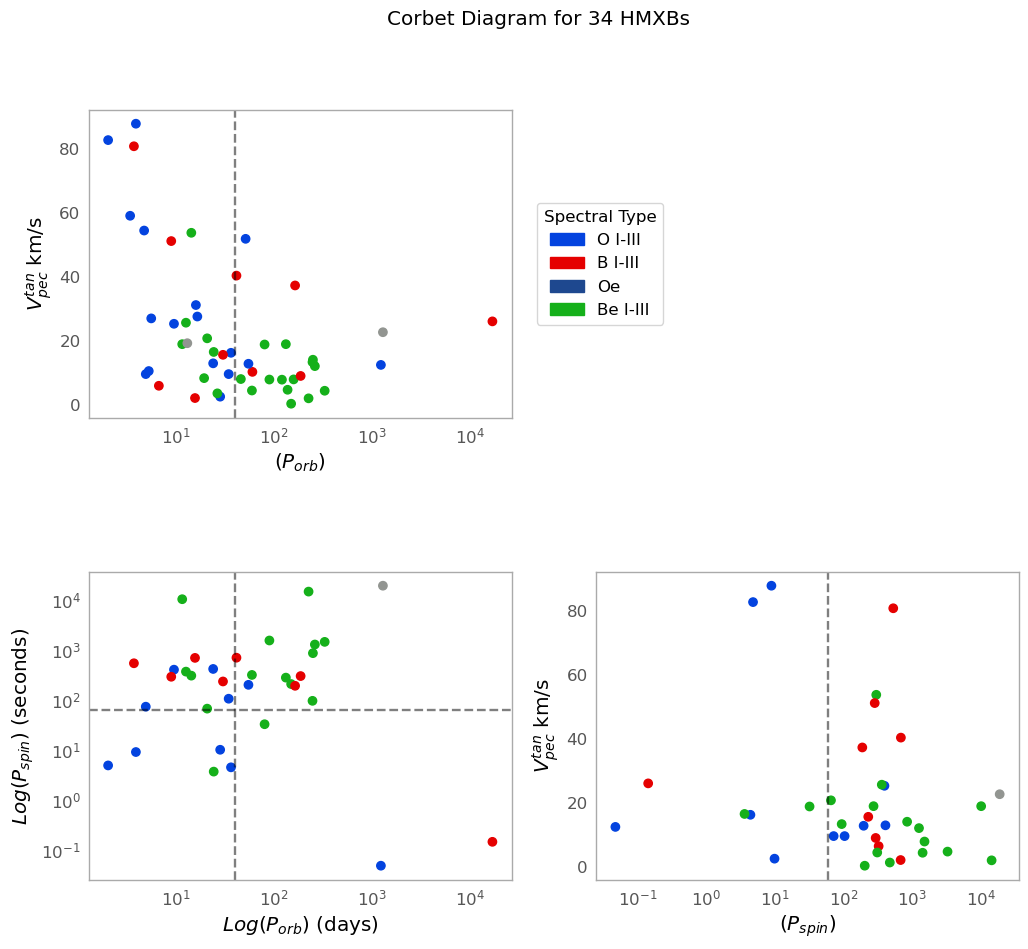

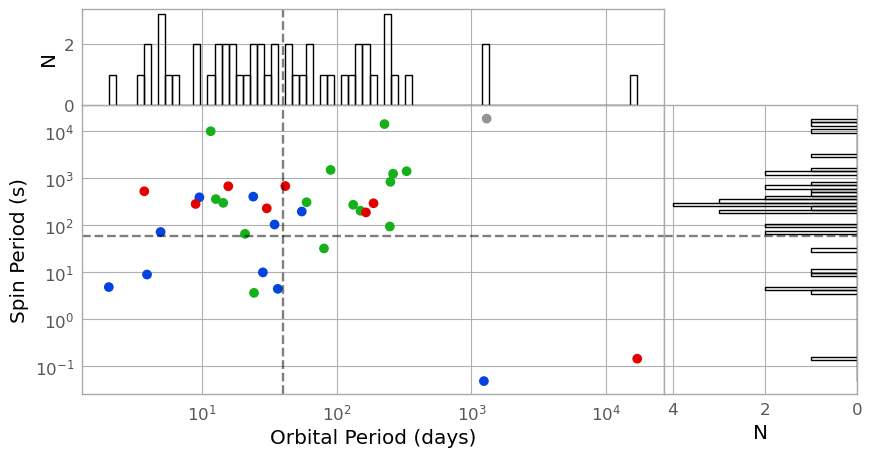

In [86]:
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
def period_spinperiod(table):
    prlx_mask = table['parallax']/table['parallax_error'] >=5.0
    table = table[prlx_mask] 
    
    orb_period = table['Period'] #days
    orb_period_err = table['Period_err'] #days
    spin_period = table['Spin_period'] # seconds
    spin_period_err = table['Spin_period_err']
    vpec = table['Peculiar Velocity']
    color = table['SpColor']

    #include thresholds Prisgen et al 2019
    orb_period_thres = 40.0
    spin_period_thres = 60.0
    
    mod_sptype = table['Mod_SpType']
    color_map = {
        "xkcd:blue": "O I-III",
        "xkcd:red": "B I-III",
        "xkcd:Bright Blue": "Oe I-III",
        "xkcd:dark blue": "Oe IV-V",
        "xkcd:green": "B0e I-III",
        "xkcd:bright green": "B1e I-III",
        "xkcd:grass green": "B2e I-III",
        "xkcd:black": "OB IV-V",
        "xkcd:grey": "M,A,None",
        "xkcd:purple": "B0e IV-V",
        "xkcd:light purple": "B1e IV-V",
        "xkcd:dark purple": "B2e IV-V",
    }
    groups = [
        ("O I-III", ['xkcd:blue'], 'xkcd:blue'),
        ("B I-III", ['xkcd:red'], 'xkcd:red'),
        ("Oe", ['xkcd:Bright Blue', 'xkcd:dark blue'], 'xkcd:cobalt'),
        ("Be I-III", ['xkcd:green', 'xkcd:bright green', 'xkcd:dark green'], 'xkcd:green')
    ]
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 1].axis('off')

    
    orb_logbins = np.logspace(np.log10(np.min(orb_period)),np.log10(np.max(orb_period)),len(orb_period+1))
    orb_bins = np.linspace(np.min(orb_period),np.max(orb_period),len(orb_period+1))
    for i in range(0,2):
        for j in range(0,2):
            axs[i, j].grid(False)
    #axs[0,0].hist(orb_period ,bins=orb_bins,edgecolor='xkcd:black')
    fill_kwargs = {'color':'k','alpha':0.5,"linestyle":"--"}
    axs[0,0].scatter(orb_period,vpec,color=color)
    axs[0,0].axvline(orb_period_thres,**fill_kwargs)
    axs[0,0].set_xscale('log')
    axs[0,0].set_xlabel(r'$(P_{orb})$')
    axs[0,0].set_ylabel(r'$V_{pec}^{tan} $ km/s')
    #axs[0,0].set_title("Histogram of Orbital Period")
    #axs[0,0].set_xscale('log')

    axs[1,0].scatter(orb_period,spin_period,color=color)
    axs[1,0].axhline(y=spin_period_thres,**fill_kwargs)
    axs[1,0].axvline(x=orb_period_thres, **fill_kwargs)
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,0].set_xlabel(r'$Log(P_{orb}$) (days)')
    axs[1,0].set_ylabel(r'$Log(P_{spin}$) (seconds)')

    spin_logbins =  np.logspace(np.log10(np.min(spin_period)),np.log10(np.max(spin_period)),len(spin_period+1))
    spin_bins =np.linspace(np.min(spin_period),np.max(spin_period),len(spin_period+1))
    
    #axs[1,1].hist(masked_spin,alpha=0.7,color='xkcd:black',histtype='step',linewidth=3.0)
    axs[1,1].scatter(spin_period,vpec,color=color)
    axs[1,1].axvline(spin_period_thres, **fill_kwargs)
    axs[1,1].set_xscale('log')
    axs[1,1].set_xlabel((r'$(P_{spin})$'))
    axs[1,1].set_ylabel(r'$V_{pec}^{tan} $ km/s')
    #axs[1,1].set_title("Histogram of Spin Period ")
   # axs[1,1].set_xscale('log')

    #corner.corner(data, labels=["alpha", "delta"], show_titles=True, fig=fig)
    #plot N points
    N = np.sum(~orb_period.mask & ~spin_period.mask)
    orb_spin_hist = table[~orb_period.mask & ~spin_period.mask]
    fig.suptitle(f'Corbet Diagram for {N} HMXBs')

    masked_orb = np.log10(orb_spin_hist['Period'])
    masked_spin = np.log10(orb_spin_hist['Spin_period'])
    data = np.array([masked_orb,masked_spin]).T
    legend_patches = [mpatches.Patch(color=group[2], label=group[0]) for group in groups]
    axs[0, 0].legend(handles=legend_patches, title="Spectral Type", loc='center left', bbox_to_anchor=(1.04, 0.5))


    fig.savefig(home_files+"/Figures/"+f"Corbet_vel_{today}.png")

    #now make the histograms
    
    hist_fig = plt.figure(figsize=(10,5))
    gs = GridSpec(4,4,figure=hist_fig,wspace=0,hspace=0)

    ax_main = hist_fig.add_subplot(gs[1:4, 0:3])  # Main scatter plot
    ax_xhist = hist_fig.add_subplot(gs[0, 0:3], sharex=ax_main)  # Top histogram
    ax_yhist = hist_fig.add_subplot(gs[1:4, 3], sharey=ax_main)

    
    ax_main.scatter(orb_period, spin_period,color=color)
    ax_main.axhline(y=spin_period_thres,**fill_kwargs)
    ax_main.axvline(x=orb_period_thres, **fill_kwargs)

    ax_main.set_xscale("log")
    ax_main.set_yscale("log")
    ax_main.set_xlabel("Orbital Period (days)")
    ax_main.set_ylabel("Spin Period (s)")
    ax_main.set_title("Corbet Diagram")
    legend_patches = [mpatches.Patch(color=group[2], label=group[0]) for group in groups]
    ax_main.legend(handles=legend_patches, title="Spectral Type", loc='center left', bbox_to_anchor=(1.04, 0.5))

    ax_xhist.hist(orb_period, orb_logbins, fill=False, edgecolor='k')
    ax_xhist.axvline(orb_period_thres, **fill_kwargs)
    ax_xhist.set_xscale("log")
    ax_xhist.set_ylabel("N")
    ax_xhist.tick_params(axis="x", labelbottom=False)
    
    # Histogram of P_spin (right)
    ax_yhist.hist(spin_period, bins=spin_logbins, fill=False, edgecolor='k', orientation="horizontal")
    ax_yhist.axhline(spin_period_thres, **fill_kwargs)
    ax_yhist.set_yscale("log")
    ax_yhist.set_xlabel("N")
    ax_yhist.invert_xaxis()
    ax_yhist.tick_params(axis="y", labelleft=False)
    hist_fig.savefig(home_files+"Figures/"+f"Corbet_hist_{today}.png")


    return None
period_spinperiod(HMXB_table)

In [87]:
# # Import Data
# df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/mpg_ggplot2.csv")

# # Create Fig and gridspec
# fig = plt.figure(figsize=(16, 10), dpi= 80)
# grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# # Define the axes
# ax_main = fig.add_subplot(grid[:-1, :-1])
# ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
# ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# # Scatterplot on main ax
# ax_main.scatter('displ', 'hwy', s=df.cty*4, c=df.manufacturer.astype('category').cat.codes, alpha=.9, data=df, cmap="tab10", edgecolors='gray', linewidths=.5)

# # histogram on the right
# ax_bottom.hist(df.displ, 40, histtype='stepfilled', orientation='vertical', color='deeppink')
# ax_bottom.invert_yaxis()

# # histogram in the bottom
# ax_right.hist(df.hwy, 40, histtype='stepfilled', orientation='horizontal', color='deeppink')

# # Decorations
# ax_main.set(title='Scatterplot with Histograms \n displ vs hwy', xlabel='displ', ylabel='hwy')
# ax_main.title.set_fontsize(20)
# for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
#     item.set_fontsize(14)

# xlabels = ax_main.get_xticks().tolist()
# ax_main.set_xticklabels(xlabels)
# plt.show()

/tmp/ipykernel_42629/182285983.py:9: RuntimeWarning: divide by zero encountered in log10
  masked_spin = np.log10(orb_spin_hist['Spin_period_err'])


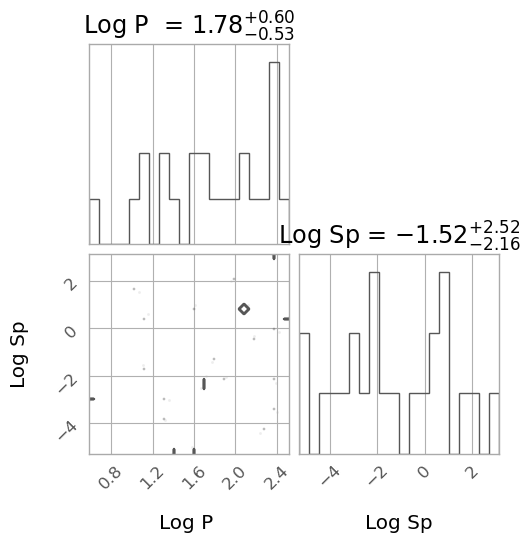

In [88]:
def make_corbet_corner(table):
    '''Make a corner plot of a corbet diagram  NOT THE CORRECT USE OF CORNER'''
    orb_period = table['Period'] #days
    orb_period_err = table['Period_err'] #days
    spin_period = table['Spin_period'] # seconds
    spin_period_err = table['Spin_period_err']
    orb_spin_hist = table[~orb_period.mask & ~spin_period.mask]
    masked_orb = np.log10(orb_spin_hist['Period'])
    masked_spin = np.log10(orb_spin_hist['Spin_period_err'])
    data = np.array([masked_orb,masked_spin]).T
    labels = ["Log P ", "Log Sp"]
    # corbet = corner.corner(
    #     data, 
    #     labels=labels, 
    #     show_titles=True, 
    #     title_fmt=".2f",
    #     #quantiles=[0.16, 0.5, 0.84], 
    #     plot_datapoints=True,
    #     #fill_contours=True,
    #     color="green",
    #     hist_kwargs={"color": "black",}
    # )
    fig = corner.corner(data, labels=labels, show_titles=True, 
                    plot_density=False,plot_datapoints=True)

    return None
make_corbet_corner(Bestars)